# Predicting the Severity of LBP

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost
from xgboost import XGBClassifier


## 1. Data Wrangling

In [2]:
#Load data
df=pd.read_csv('/Users/nirathikeerthi/Desktop/Springboard/Capstone 3 - LBP/LBP_data.csv')

In [3]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Participant No.        60 non-null     int64  
 1   Gender                 60 non-null     object 
 2   Age                    60 non-null     int64  
 3   Height                 60 non-null     int64  
 4   Weight                 60 non-null     int64  
 5   BMI                    60 non-null     float64
 6   Ethnicity              60 non-null     object 
 7   History                60 non-null     object 
 8   Physical_activity      60 non-null     int64  
 9   Alcohol                60 non-null     int64  
 10  Smoking                60 non-null     int64  
 11  Hours/day              60 non-null     object 
 12  Years                  54 non-null     float64
 13  Occ_Score              60 non-null     int64  
 14  Posture                60 non-null     int64  
 15  Force   

In [4]:
df.drop(columns='Participant No.', inplace=True)

In [5]:
# No. of rows and columns
df.shape

(60, 28)

In [6]:
#visualize
df.head()

Gender  Age  Height  Weight        BMI  Ethnicity History  \
0      F   37      62     162  29.626951  Caucasian     Yes   
1      M   72      64     184  31.580078  Caucasian     Yes   
2      F   56      65     168  27.953609  Caucasian      No   
3      F   60      65     218  36.273136      Black      No   
4      M   38      72     209  28.342400  Caucasian      No   

   Physical_activity  Alcohol  Smoking  ...   JCQ_Score  Decision_Latitude  \
0                  1        1        1  ...  162.000000                 78   
1                  4        2        3  ...  183.100000                 70   
2                  1        2        3  ...  152.566667                 66   
3                  6        3        4  ...  172.566667                 72   
4                  1        3        1  ...  145.000000                 74   

   Physical_Demands  Psychological_Demands  Social_Support  \
0                 5                      8              38   
1                10                      8              31   
2                16                      6              33   
3                19                     16              30   
4                10                      2              30   

   Organizational_Level  Job_Satisfaction  Job_Security  ODI_Score    VAS  
0                    34          0.000000            -1         30  10.00  
1                    61          0.100000             3         70  10.00  
2                    30          0.566667             1         94   9.84  
3                    29          0.566667             6         44   8.27  
4                    28          0.000000             1         40   7.01  

[5 rows x 28 columns]

In [7]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    6
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         1
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

In [8]:
#Checking for missing values
df.isin(['?']).sum(axis=0)

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         0
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

In [9]:
# Calculate average ODI and VAS by History and sort by the average of the two
history_means = df.groupby('History')[['ODI_Score', 'VAS']].mean()
history_means.head()

ODI_Score       VAS
History                     
No       38.750000  8.095417
Yes      43.222222  7.738333

In [10]:
# Calculate average ODI and VAS by Gender and sort by the average of the two
gender_means = df.groupby('Gender')[['ODI_Score', 'VAS']].mean()
gender_means.head()

ODI_Score       VAS
Gender                     
F       41.352941  7.929706
M       41.538462  7.817692

In [11]:
# Calculate average ODI and VAS by Ethnicity and sort by the average of the two
ethnicity_means = df.groupby('Ethnicity')[['ODI_Score', 'VAS']].mean()
ethnicity_means.head()

ODI_Score       VAS
Ethnicity                     
Black      43.444444  7.134444
Caucasian  41.641026  8.157179
Other      26.666667  8.773333

In [12]:
df['Ethnicity'].value_counts()

Caucasian    39
Black        18
Other         3
Name: Ethnicity, dtype: int64

In [13]:
# Calculate average ODI and VAS by Hours/day and sort by the average of the two
hours_means = df.groupby('Hours/day')[['ODI_Score', 'VAS']].mean()
hours_means.head()

ODI_Score       VAS
Hours/day                     
10         42.363636  8.528182
11         16.000000  8.280000
12         42.857143  8.228571
16         56.000000  4.170000
2          48.000000  8.130000

In [14]:
df['Hours/day'].value_counts()

8      22
10     11
12      7
5       4
9       4
6       4
4       2
>8      1
16      1
>8      1
11      1
2       1
7       1
Name: Hours/day, dtype: int64

In [19]:
df.replace('>8 ','99',inplace=True)

In [20]:
df['Hours/day'].value_counts()

8     22
10    11
12     7
5      4
9      4
6      4
99     2
4      2
2      1
11     1
7      1
16     1
Name: Hours/day, dtype: int64

In [23]:
df['Hours/day'] = df['Hours/day'].astype(int)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 60 non-null     object 
 1   Age                    60 non-null     int64  
 2   Height                 60 non-null     int64  
 3   Weight                 60 non-null     int64  
 4   BMI                    60 non-null     float64
 5   Ethnicity              60 non-null     object 
 6   History                60 non-null     object 
 7   Physical_activity      60 non-null     int64  
 8   Alcohol                60 non-null     int64  
 9   Smoking                60 non-null     int64  
 10  Hours/day              60 non-null     int64  
 11  Years                  54 non-null     float64
 12  Occ_Score              60 non-null     int64  
 13  Posture                60 non-null     int64  
 14  Force                  60 non-null     int64  
 15  Repetiti

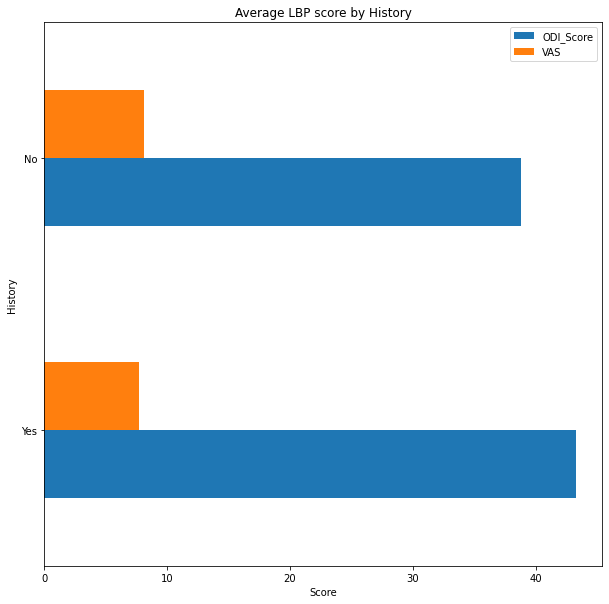

In [21]:
(history_means.reindex(index=history_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Average LBP score by History'))
plt.xlabel('Score');

In [25]:
df.describe().transpose()

count        mean        std         min         25%  \
Age                     60.0   47.083333  16.172053   20.000000   33.000000   
Height                  60.0   67.033333   3.875025   59.000000   64.000000   
Weight                  60.0  184.533333  37.726252   95.000000  160.000000   
BMI                     60.0   28.859479   5.348535   16.826657   25.807846   
Physical_activity       60.0    2.533333   1.599435    1.000000    1.000000   
Alcohol                 60.0    1.750000   0.772954    1.000000    1.000000   
Smoking                 60.0    1.600000   1.028410    1.000000    1.000000   
Hours/day               60.0   11.533333  16.553423    2.000000    8.000000   
Years                   54.0   12.722222  10.901647    1.000000    4.000000   
Occ_Score               60.0   12.283333   6.279079    3.000000    6.000000   
Posture                 60.0    6.300000   1.985541    3.000000    5.000000   
Force                   60.0    3.466667   2.346773    0.000000    1.000000   
Repetition              60.0    1.733333   2.146078    0.000000    0.000000   
Vibration               60.0    0.783333   1.574066    0.000000    0.000000   
PSS_Score               60.0   27.033333   6.998709    9.000000   24.750000   
JCQ_Score               60.0  165.148056  23.956523  105.466667  148.933333   
Decision_Latitude       60.0   70.266667  10.801548   38.000000   64.000000   
Physical_Demands        60.0   12.933333   4.368092    5.000000   10.000000   
Psychological_Demands   60.0    9.133333   4.292156   -1.000000    7.000000   
Social_Support          60.0   33.650000  11.634002   18.000000   29.000000   
Organizational_Level    60.0   37.500000  12.099167   19.000000   29.000000   
Job_Satisfaction        59.0    0.303107   0.258597    0.000000    0.100000   
Job_Security            60.0    1.366667   2.629472   -1.000000   -1.000000   
ODI_Score               60.0   41.433333  16.143810   16.000000   31.500000   
VAS                     60.0    7.881167   1.696686    3.460000    6.750000   

                              50%        75%         max  
Age                     48.000000   57.25000   83.000000  
Height                  66.000000   70.00000   75.000000  
Weight                 180.000000  211.25000  275.000000  
BMI                     28.233276   31.65558   42.126754  
Physical_activity        3.000000    4.00000    6.000000  
Alcohol                  2.000000    2.00000    3.000000  
Smoking                  1.000000    2.00000    5.000000  
Hours/day                8.000000   10.00000   99.000000  
Years                   10.000000   20.00000   50.000000  
Occ_Score               12.000000   17.25000   27.000000  
Posture                  6.000000    8.00000   10.000000  
Force                    4.000000    5.00000    7.000000  
Repetition               0.000000    4.00000    7.000000  
Vibration                0.000000    0.00000    5.000000  
PSS_Score               28.000000   31.00000   40.000000  
JCQ_Score              159.433333  186.02500  227.300000  
Decision_Latitude       70.000000   78.00000   92.000000  
Physical_Demands        14.000000   15.25000   20.000000  
Psychological_Demands    8.000000   12.00000   20.000000  
Social_Support          31.000000   33.00000   88.000000  
Organizational_Level    33.000000   43.00000   64.000000  
Job_Satisfaction         0.200000    0.50000    1.000000  
Job_Security             1.000000    2.25000   11.000000  
ODI_Score               38.000000   50.00000   94.000000  
VAS                      8.050000    9.31000   10.000000

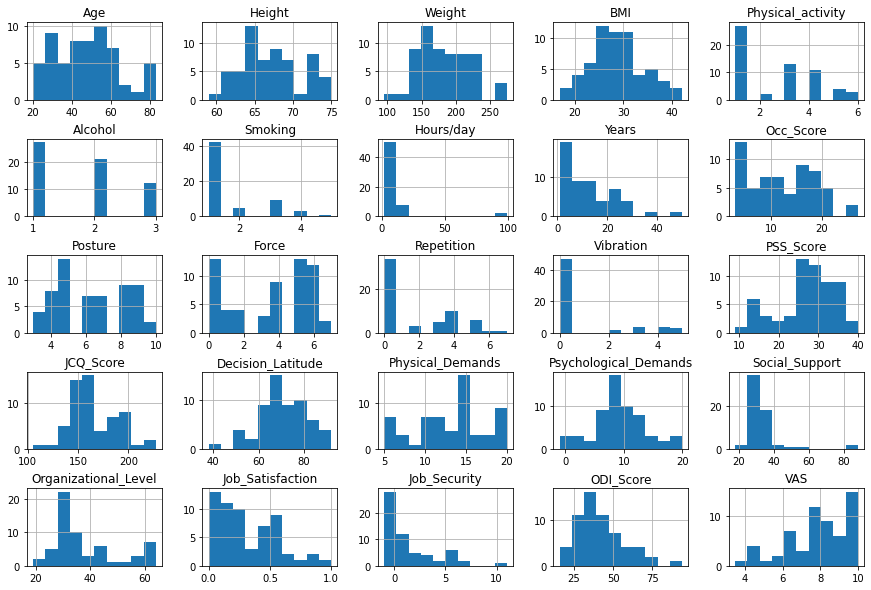

In [26]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [27]:
df['Years'].value_counts()

1.0     5
2.0     5
10.0    4
4.0     4
3.0     3
22.0    3
15.0    3
30.0    3
20.0    3
11.0    2
25.0    2
13.0    2
5.0     2
12.0    2
7.0     2
9.0     1
21.0    1
26.0    1
40.0    1
24.0    1
16.0    1
6.0     1
50.0    1
8.0     1
Name: Years, dtype: int64

In [28]:
df=df.fillna(df.median())

In [29]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         0
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

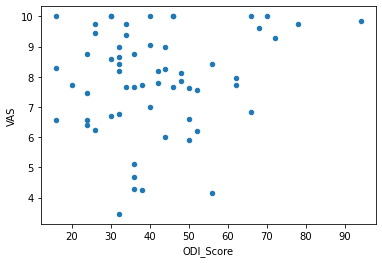

In [30]:
# Target Feature
df.plot(x='ODI_Score', y='VAS', kind='scatter');

In [31]:
df['ODI_Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI_Score, dtype: int64

In [32]:
df['VAS'].value_counts()

10.00    8
9.76     3
7.66     3
6.56     2
7.72     2
8.43     2
4.17     1
7.48     1
7.56     1
9.45     1
6.61     1
8.67     1
5.12     1
6.25     1
9.29     1
6.85     1
7.64     1
4.69     1
7.01     1
7.97     1
8.75     1
7.79     1
4.30     1
8.98     1
9.00     1
6.69     1
6.02     1
3.46     1
6.77     1
9.06     1
7.73     1
8.19     1
6.22     1
8.13     1
8.28     1
8.74     1
8.59     1
8.20     1
5.91     1
9.61     1
4.25     1
8.27     1
7.87     1
9.37     1
6.41     1
9.84     1
Name: VAS, dtype: int64

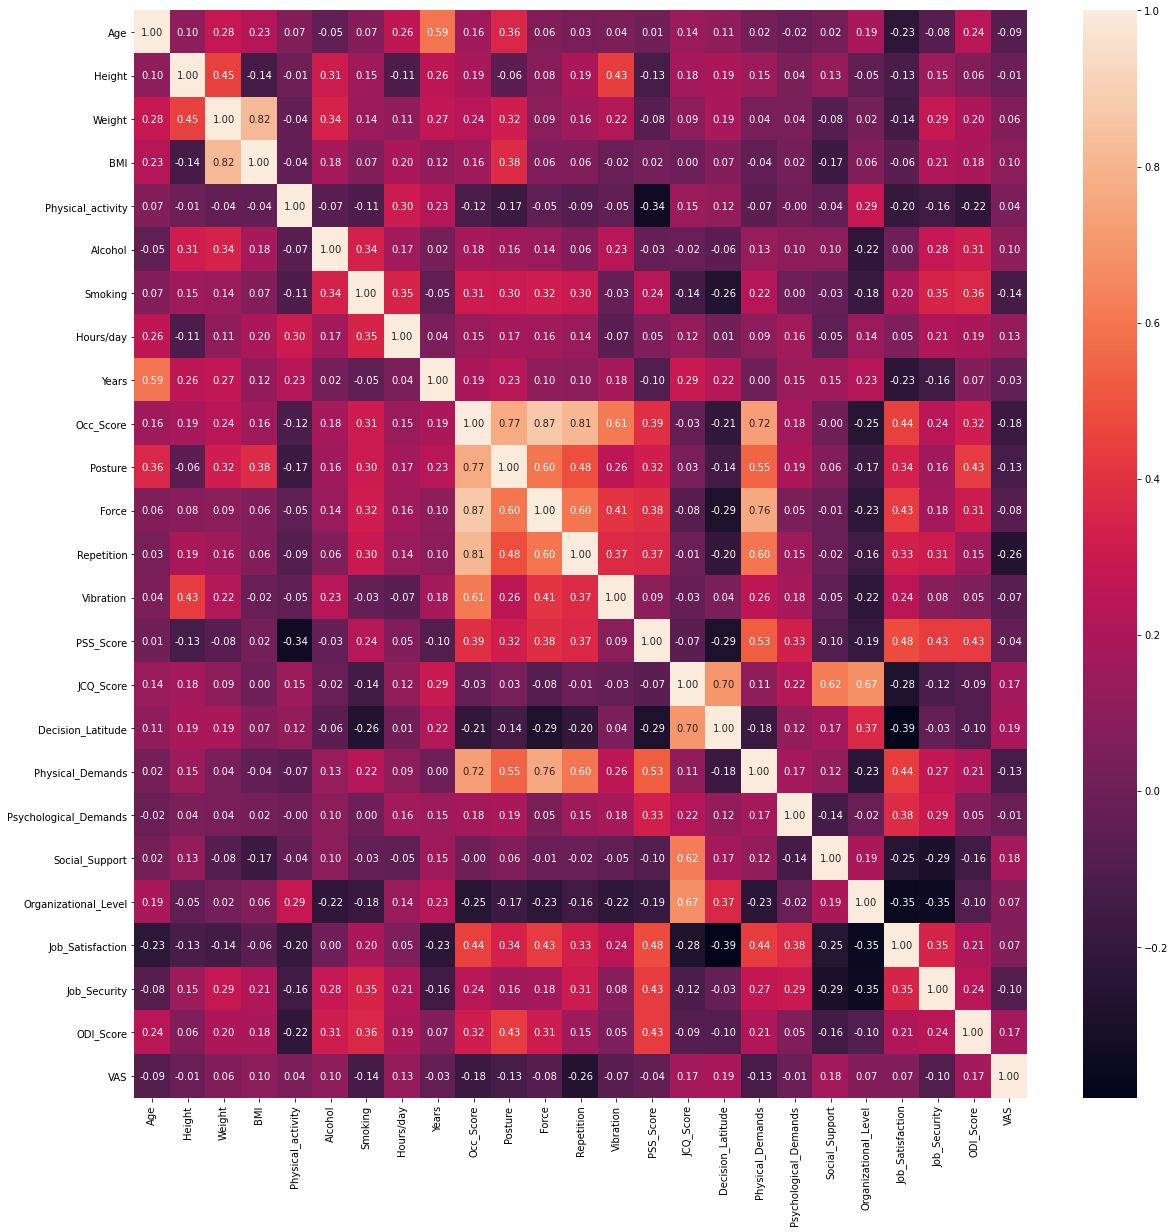

In [33]:
#Visualize correlation of the target variable with other features
plt.subplots(figsize=(20,20))

corr = df.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

## 2. EDA

In [34]:
#Scatter Plots
# define useful function to create scatterplots against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'ODI_Score', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='ODI_Score')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [37]:
features = [column for column in df.columns if column not in ['Gender', 'History', 'Ethnicity', 'VAS', 'ODI_Score']]

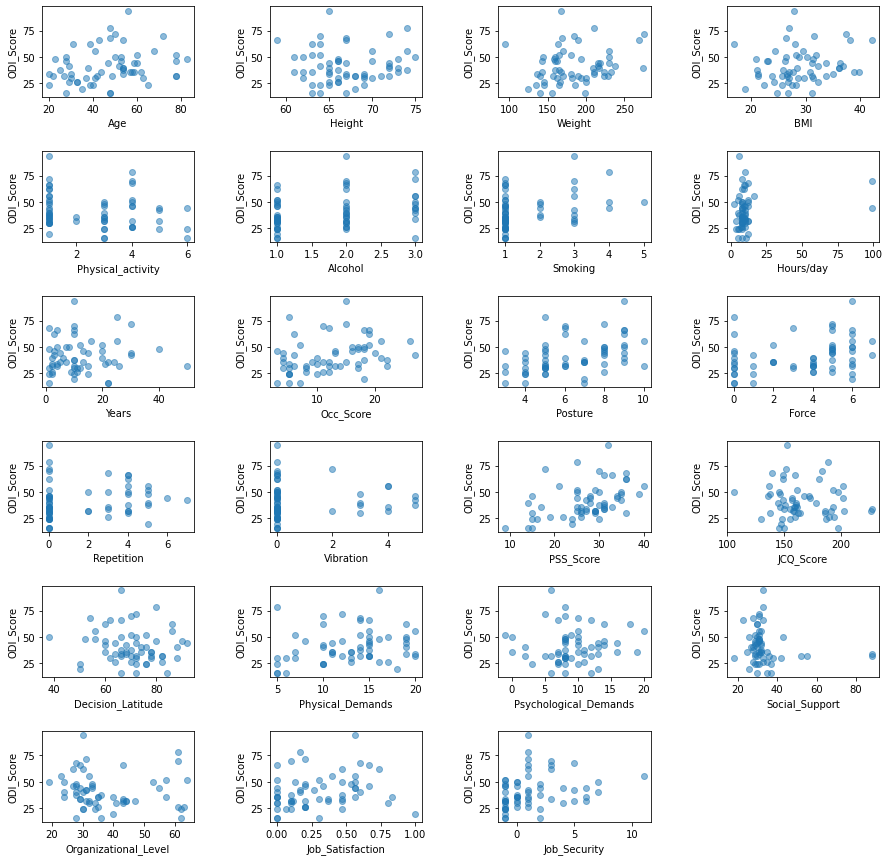

In [38]:
scatterplots(features, ncol=4, figsize=(15, 15))

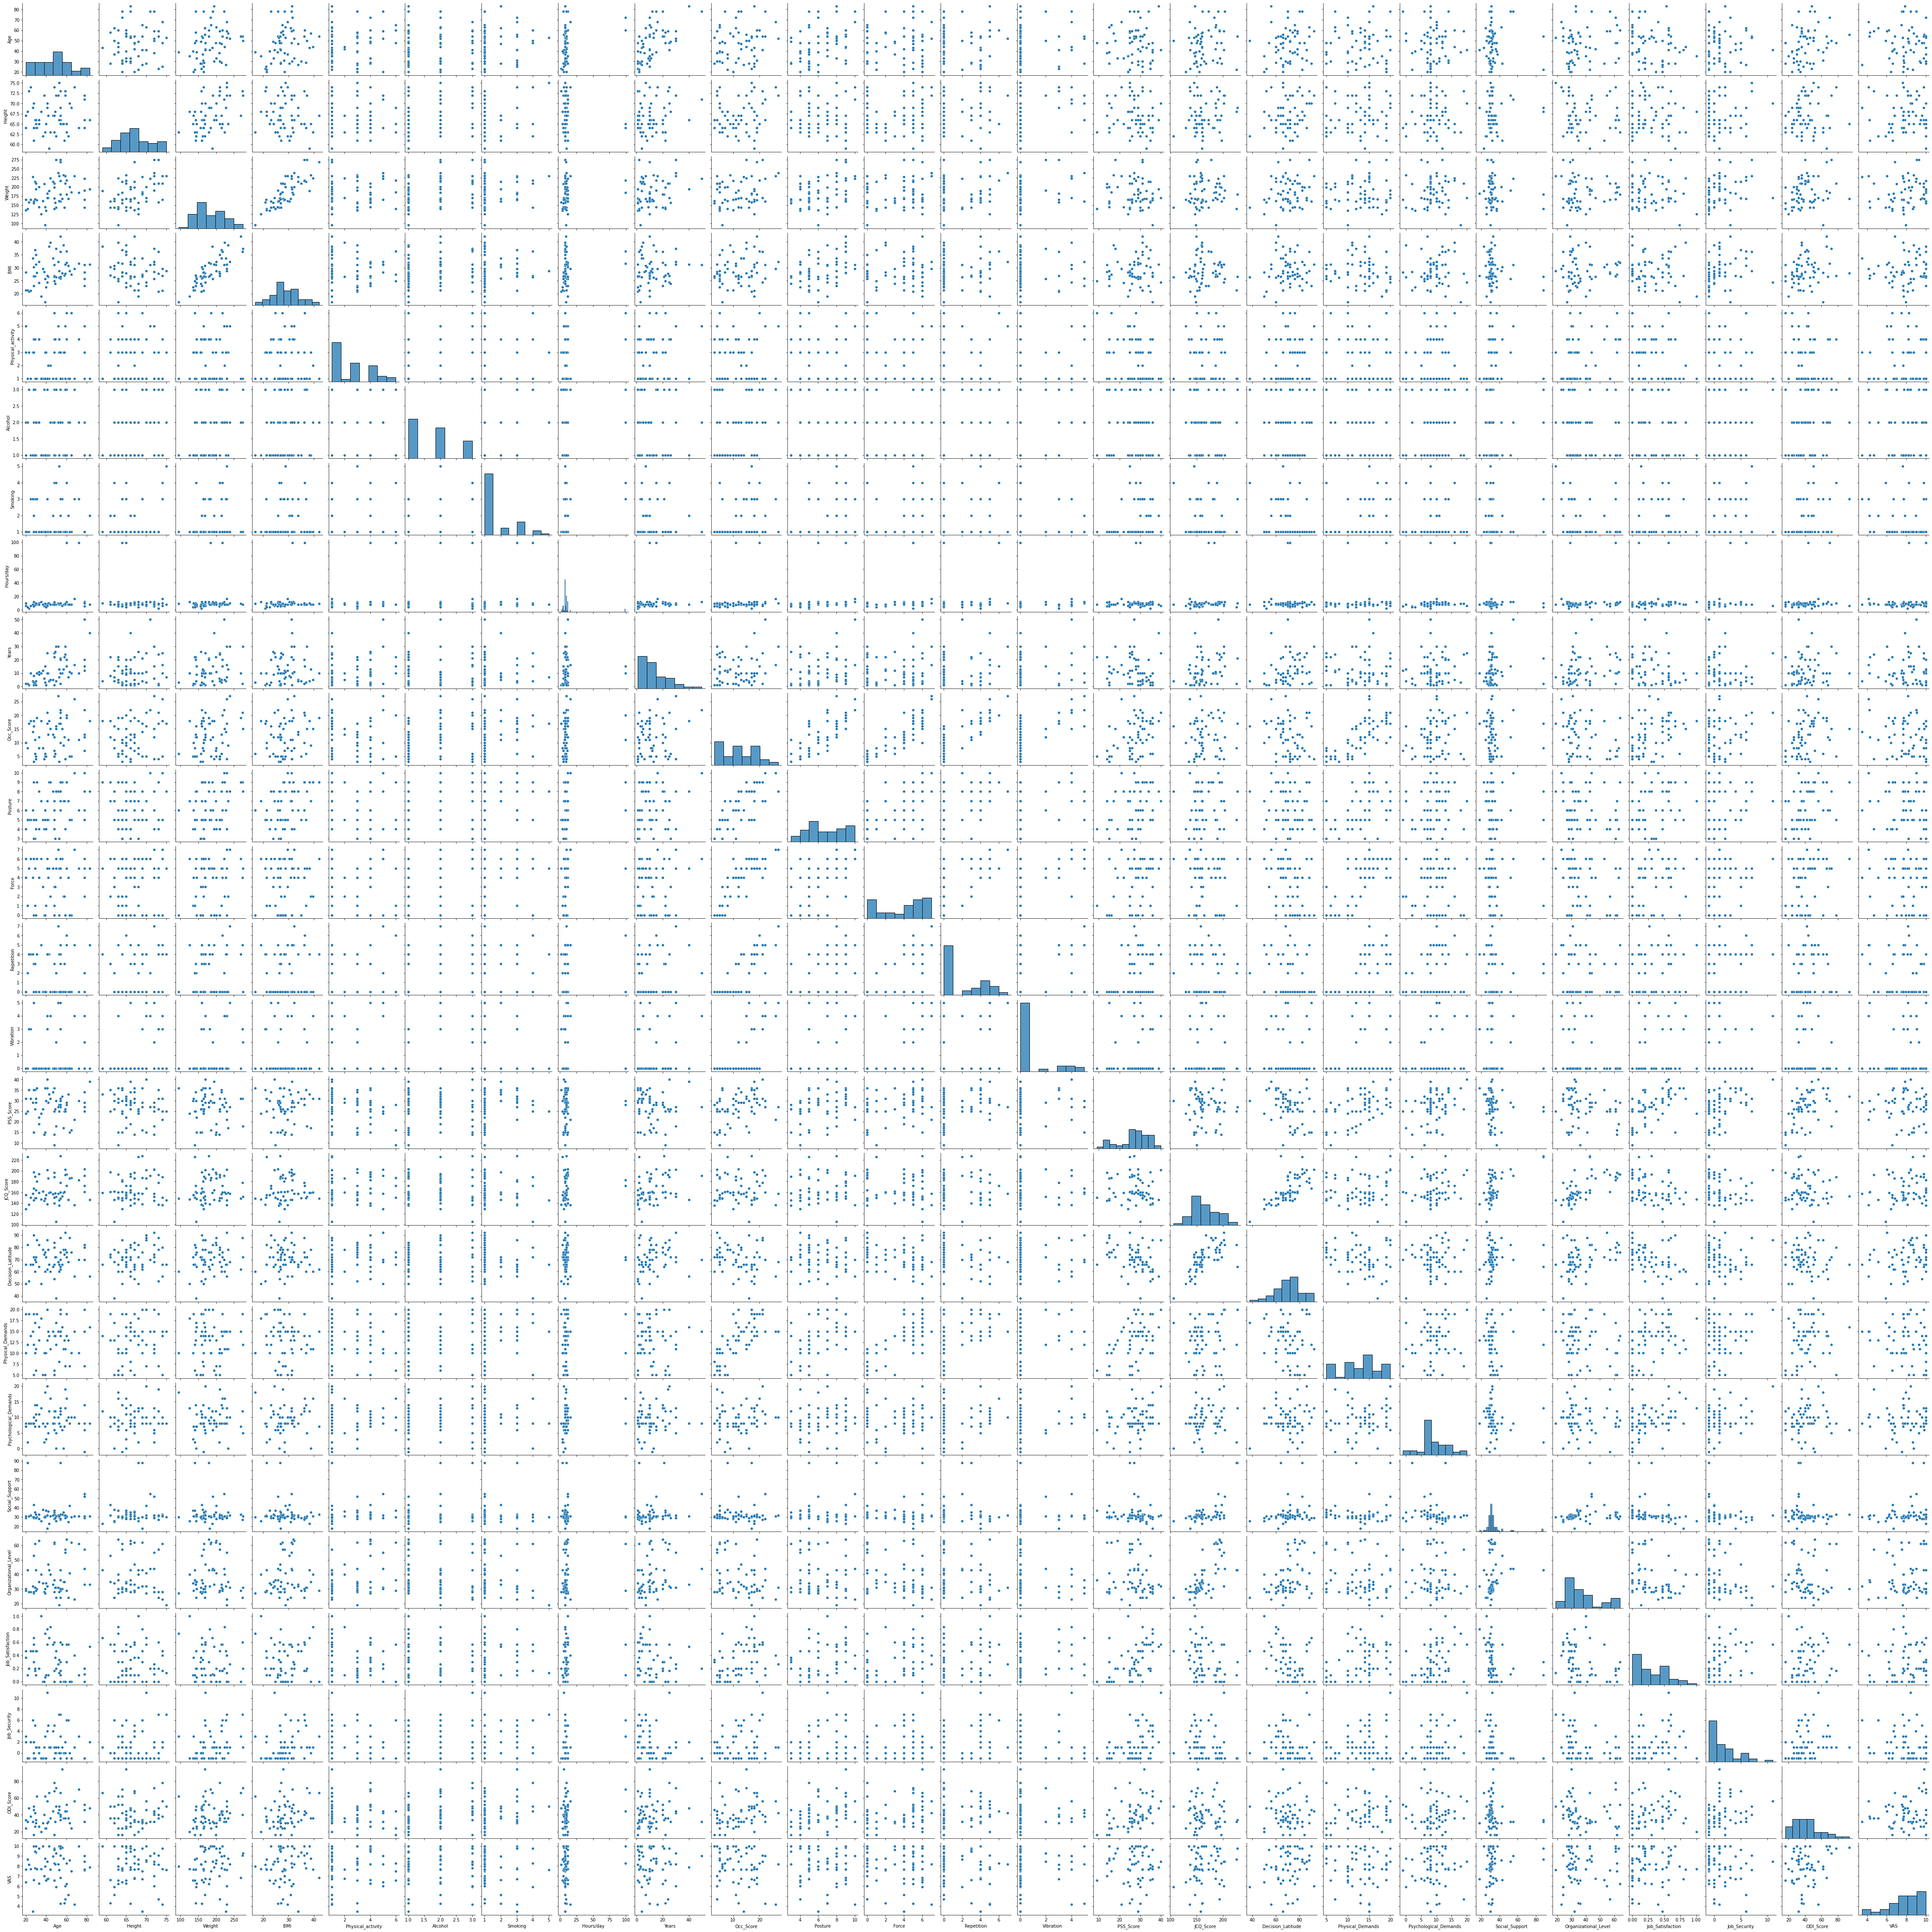

In [39]:
# Make a pairplot of the data
sns.pairplot(df)

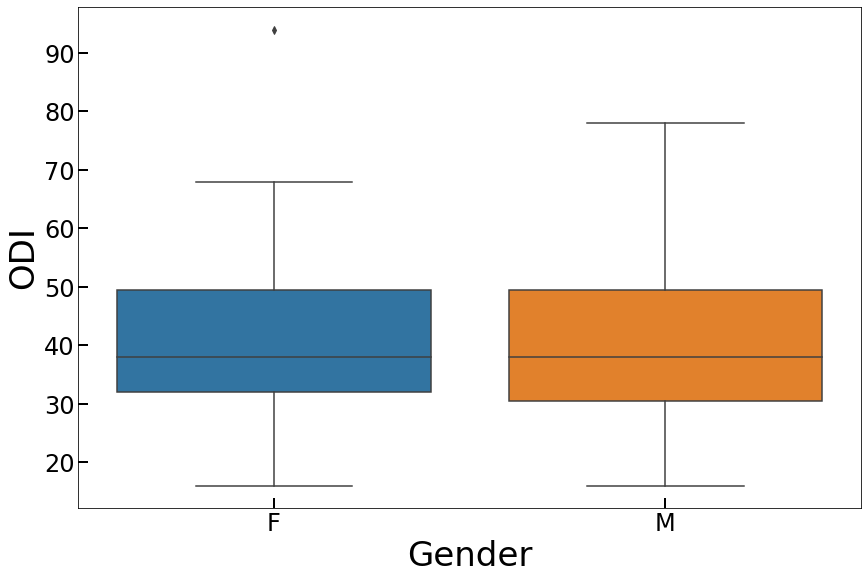

Median value Gender
F    38
M    38
Name: ODI_Score, dtype: int64


In [40]:
# Use the boxplot() method to see if Gender has any effect on ODI
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Gender', y='ODI_Score',data=df)
plt.xlabel('Gender',fontsize=34)
plt.ylabel('ODI',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('Gender')['ODI_Score'].median()
print("Median value", Gender_median)


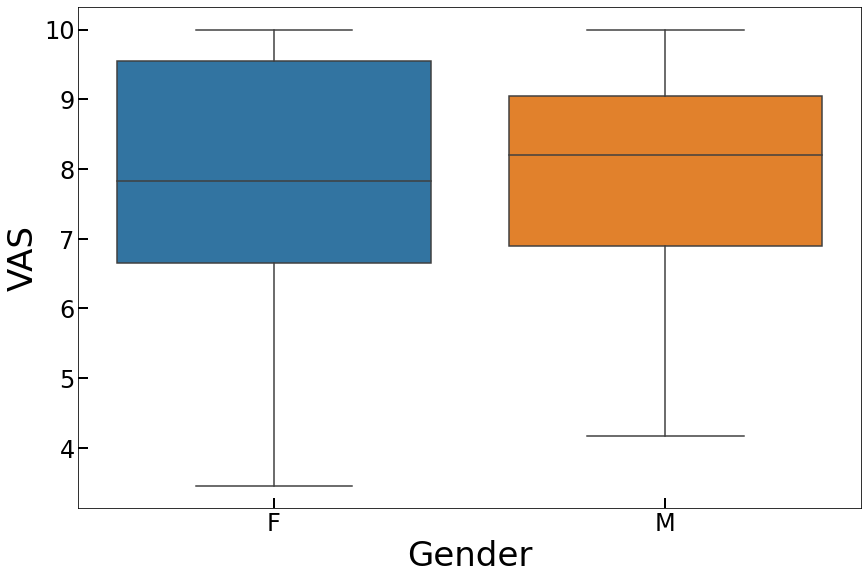

Median value Gender
F    7.830
M    8.195
Name: VAS, dtype: float64


In [41]:
# Use the boxplot() method to see if Gender has any effect on VAS
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Gender', y='VAS',data=df)
plt.xlabel('Gender',fontsize=34)
plt.ylabel('VAS',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('Gender')['VAS'].median()
print("Median value", Gender_median)

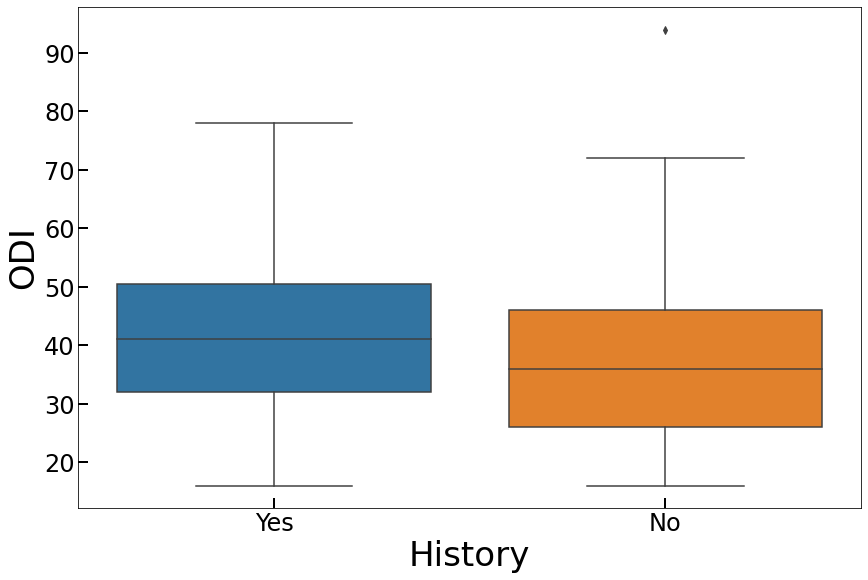

Median value History
No     36
Yes    41
Name: ODI_Score, dtype: int64


In [42]:
# Use the boxplot() method to see if Family history has any effect on ODI
plt.subplots(figsize=(12, 8))
sns.boxplot(x='History', y='ODI_Score',data=df)
plt.xlabel('History',fontsize=34)
plt.ylabel('ODI',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('History')['ODI_Score'].median()
print("Median value", Gender_median)

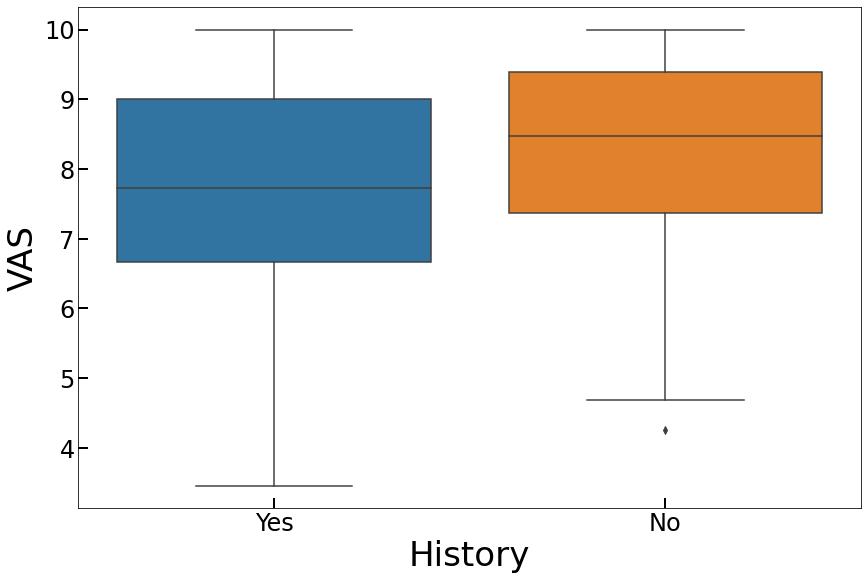

Median value History
No     8.475
Yes    7.725
Name: VAS, dtype: float64


In [43]:
# Use the boxplot() method to see if Family history has any effect on VAS
plt.subplots(figsize=(12, 8))
sns.boxplot(x='History', y='VAS',data=df)
plt.xlabel('History',fontsize=34)
plt.ylabel('VAS',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('History')['VAS'].median()
print("Median value", Gender_median)

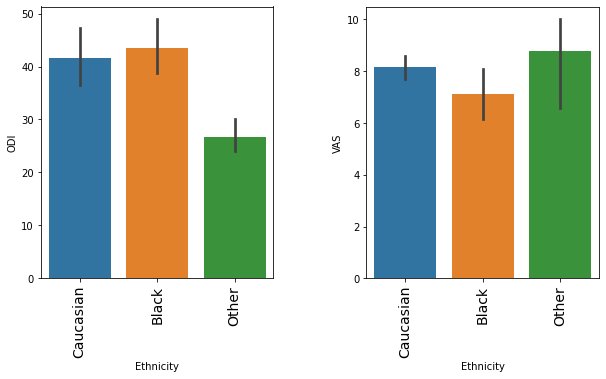

In [44]:
# Check Ethnicity
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
g1=sns.barplot(x="Ethnicity", y="ODI_Score", data=df,ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90,size=14)
g1.set(ylabel='ODI')
#g1.set(xlabel=None)
g2=sns.barplot(x="Ethnicity", y="VAS", data=df,ax=ax[1])
g2.set_xticklabels (g2.get_xticklabels(), rotation=90,size=14)
g2.set(ylabel='VAS')
plt.subplots_adjust(wspace=0.4)

plt.show()

In [45]:
#Create dataframe with only personal factors
personal_df = df[['Gender','Age','Height', 'Weight', 'BMI', 'Ethnicity', 'History', 'Physical_activity', 'Alcohol', 'Smoking']]

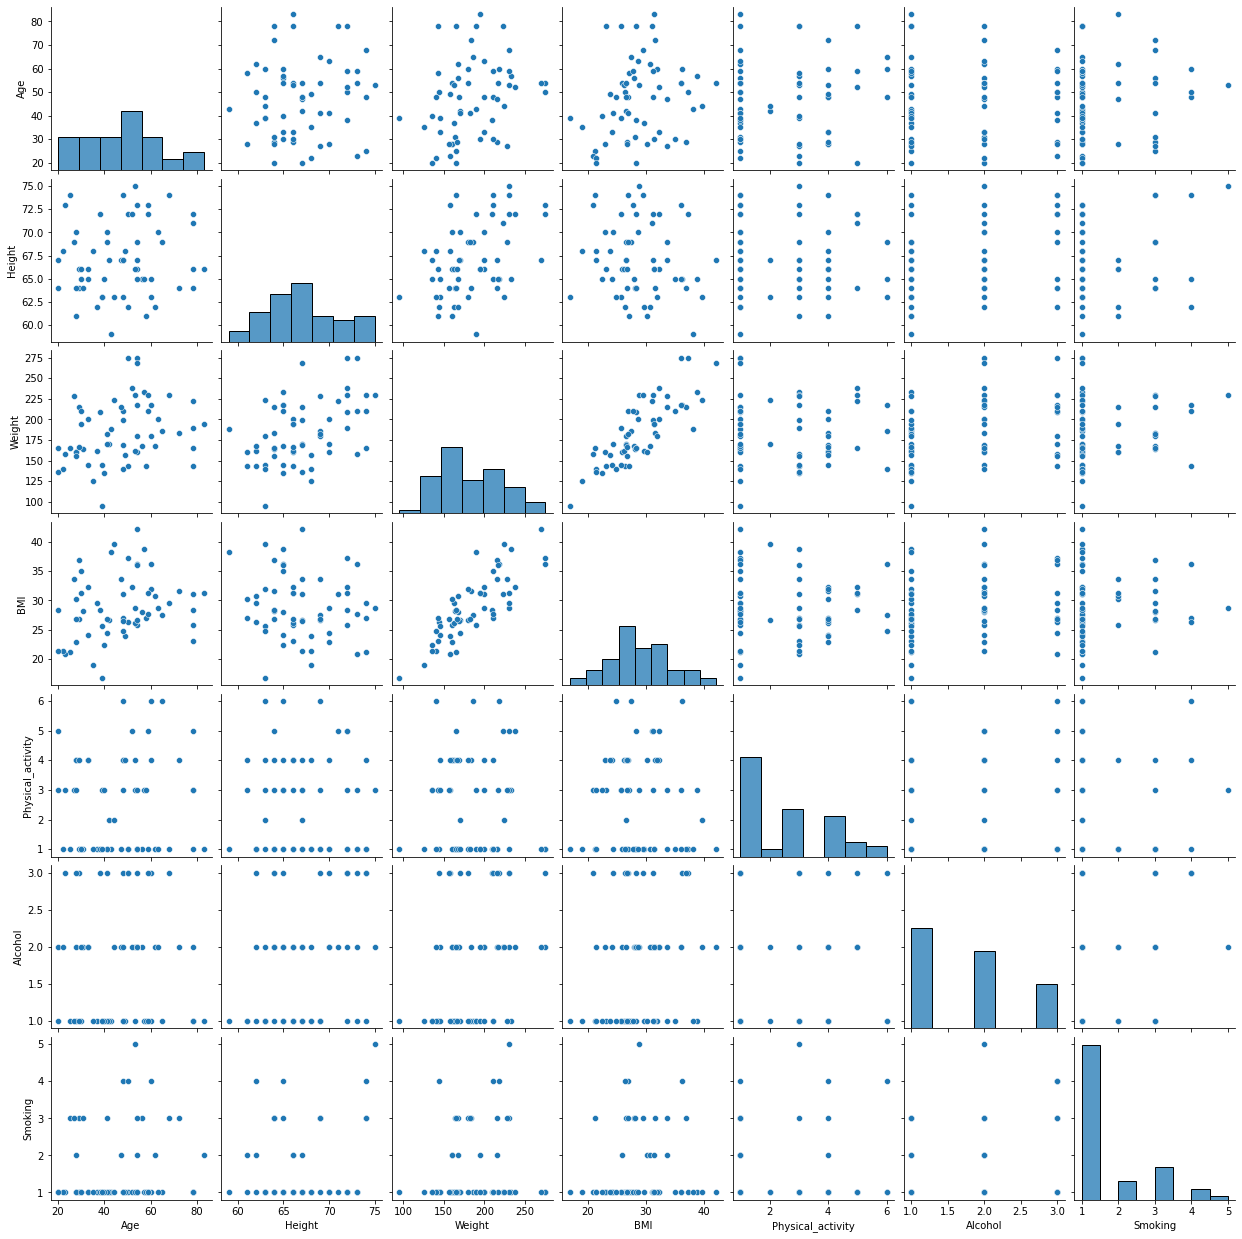

In [46]:
# Make a pairplot of the data
sns.pairplot(personal_df)

In [47]:
#Create dataframe with only occupational factors
occ_df = df[['Hours/day','Years','Occ_Score', 'Posture', 'Force', 'Repetition', 'Vibration']]

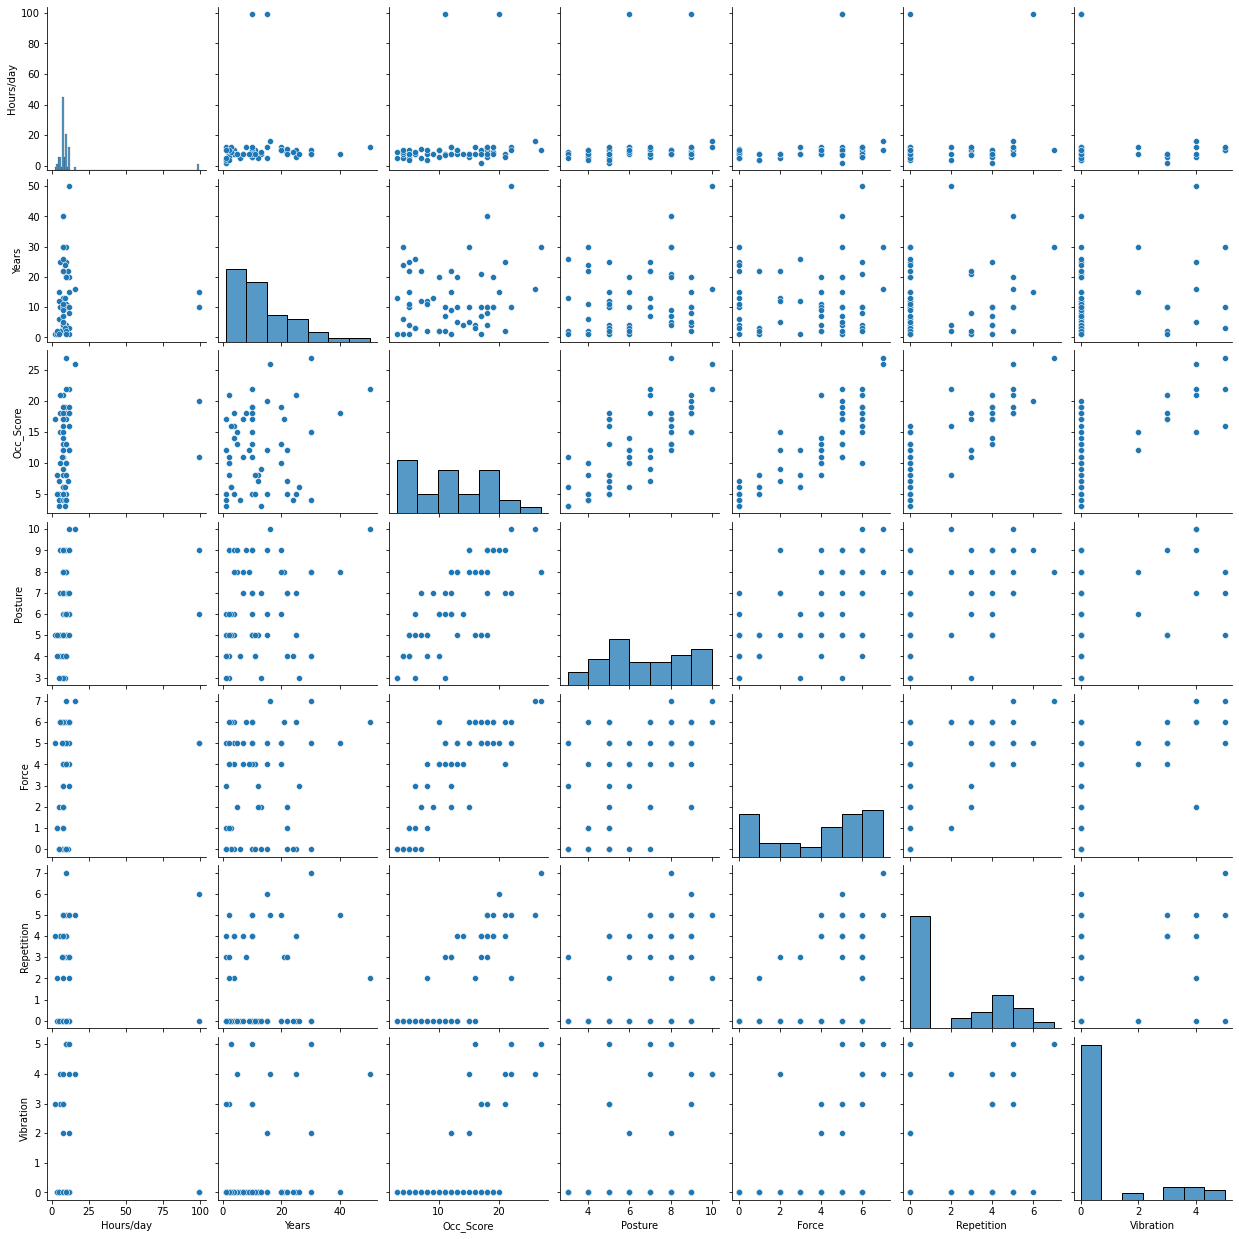

In [48]:
# Make a pairplot of the data
sns.pairplot(occ_df)

In [49]:
#Create dataframe with only psychosocial factors
psy_df = df[['PSS_Score','JCQ_Score','Decision_Latitude', 'Physical_Demands', 'Psychological_Demands', 'Social_Support', 'Organizational_Level', 'Job_Satisfaction', 'Job_Security']]

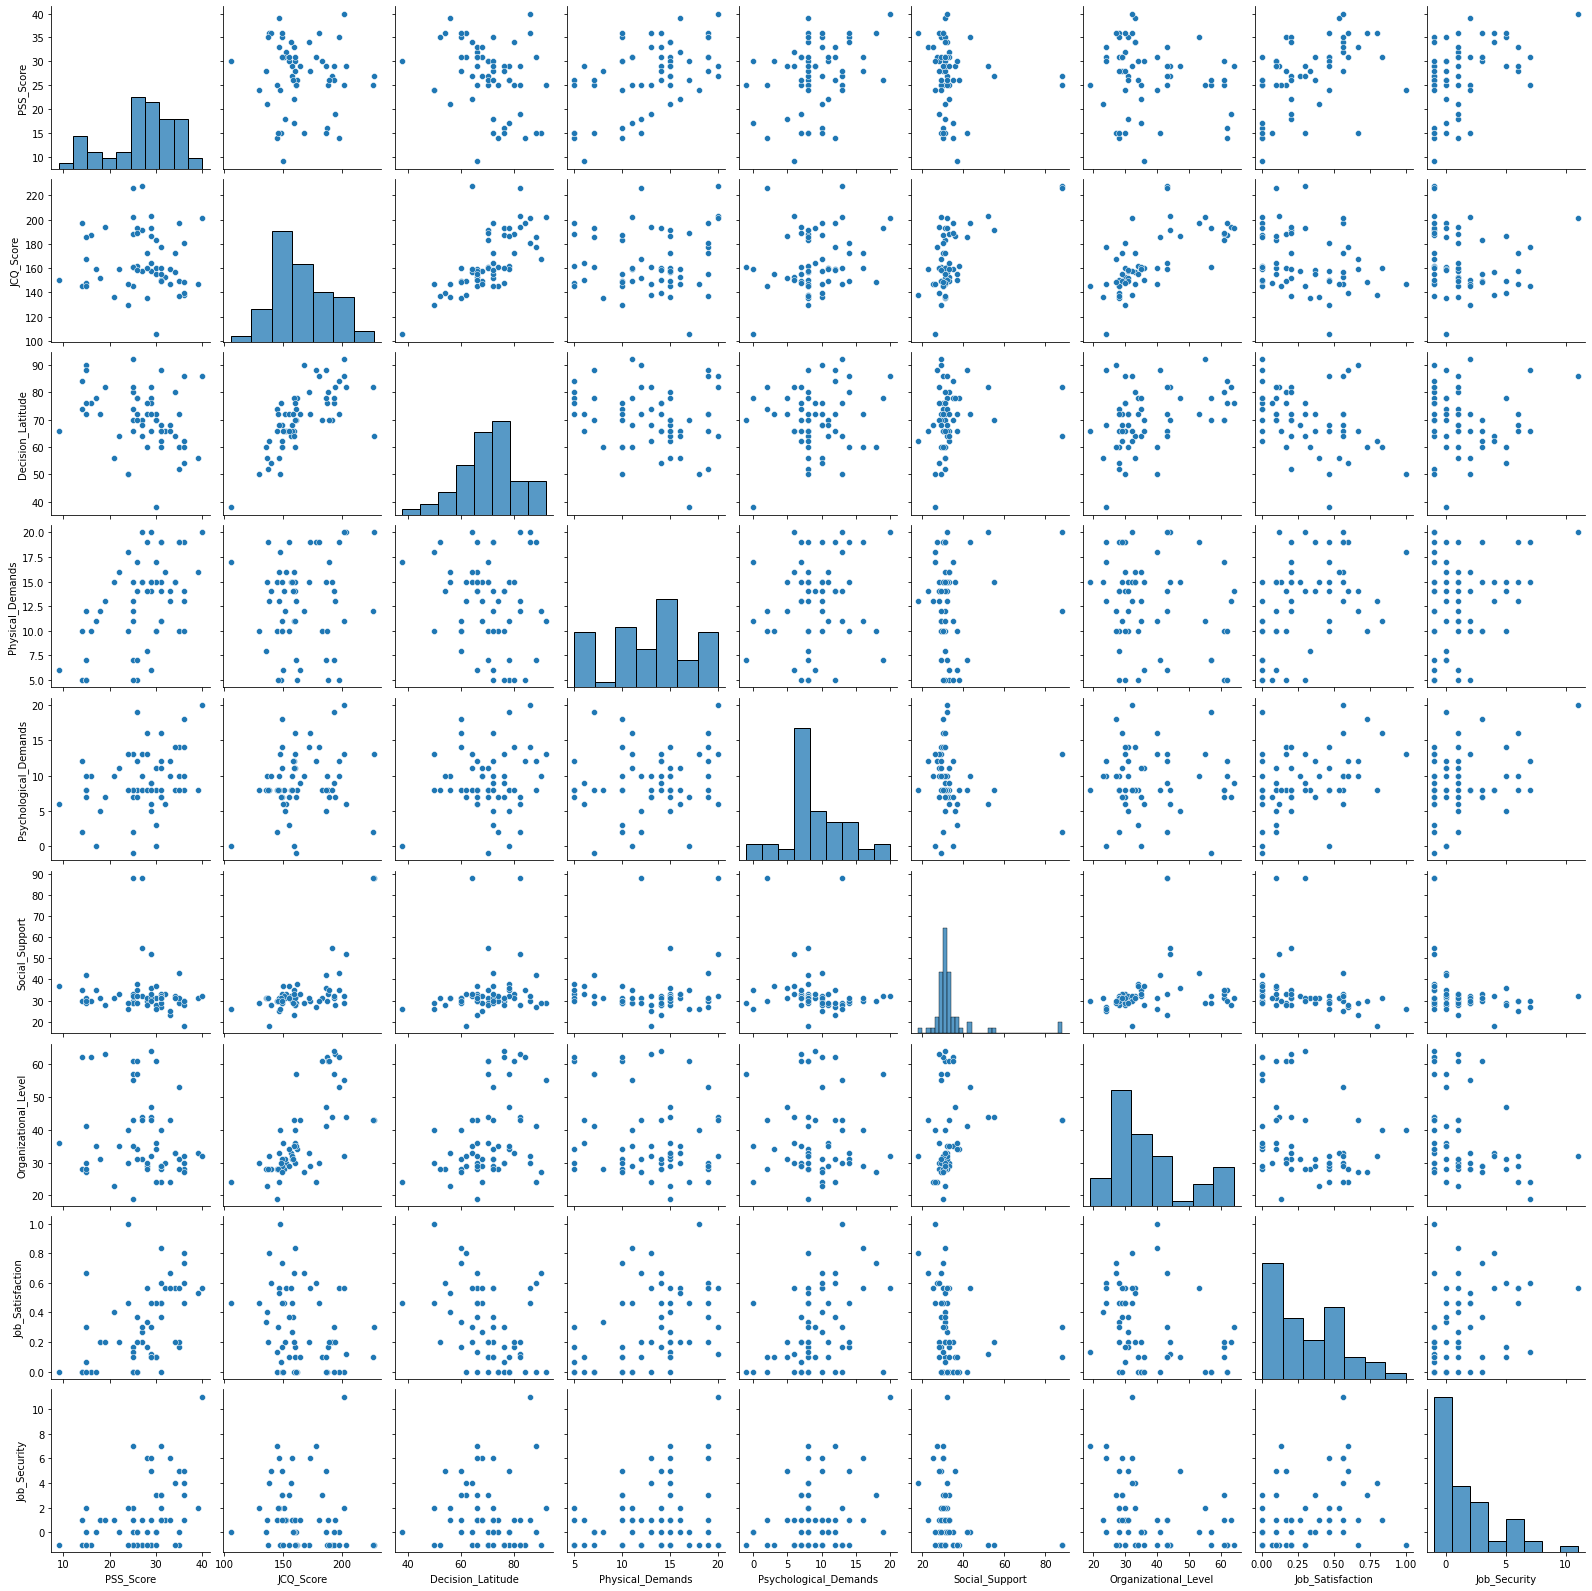

In [50]:
# Make a pairplot of the data
sns.pairplot(psy_df)

## 3. Preprocessing & Feature Selection

In [55]:
df['BMI'].value_counts()

31.308999    2
28.319092    2
27.464398    1
25.821855    1
23.869161    1
26.466251    1
36.145994    1
31.164402    1
33.666037    1
27.703134    1
36.273136    1
25.682792    1
29.626951    1
38.169204    1
31.098790    1
36.106746    1
29.527027    1
22.955102    1
34.942012    1
38.768994    1
26.335068    1
20.843310    1
21.298285    1
24.389796    1
22.462722    1
26.873766    1
26.790174    1
33.670082    1
39.675485    1
28.342400    1
30.724246    1
19.004109    1
26.959459    1
31.190201    1
42.126754    1
36.900635    1
31.580078    1
21.284602    1
28.744889    1
27.016662    1
16.826657    1
25.765818    1
26.578450    1
26.144628    1
31.882086    1
28.147461    1
37.292631    1
27.953609    1
24.126627    1
32.275077    1
21.182432    1
32.277319    1
30.228433    1
28.693878    1
26.622856    1
24.797178    1
26.774414    1
23.078283    1
Name: BMI, dtype: int64

In [62]:
bins = [0, 25, 30, np.inf]
labels = ['Normal', 'Overweight', 'Obese']
df['BMI_cat'] = pd.cut(df['BMI'], bins, labels=labels)

In [63]:
df['BMI_cat'].value_counts()

Overweight    24
Obese         23
Normal        13
Name: BMI_cat, dtype: int64

In [64]:
df['Physical_activity'].value_counts()

1    27
3    13
4    11
5     4
6     3
2     2
Name: Physical_activity, dtype: int64

In [65]:
bins = [0, 3, 6]
labels = ['No to Low', 'Mod to High']
df['Phy_act_cat'] = pd.cut(df['Physical_activity'], bins, labels=labels)

In [66]:
df['Phy_act_cat'].value_counts()

No to Low      42
Mod to High    18
Name: Phy_act_cat, dtype: int64

In [68]:
df['Alcohol'].value_counts()

1    27
2    21
3    12
Name: Alcohol, dtype: int64

In [69]:
bins = [0, 1, 3]
labels = ['No', 'Yes']
df['Alcohol_cat'] = pd.cut(df['Alcohol'], bins, labels=labels)

In [70]:
df['Alcohol_cat'].value_counts()

Yes    33
No     27
Name: Alcohol_cat, dtype: int64

In [71]:
df['Smoking'].value_counts()

1    42
3     9
2     5
4     3
5     1
Name: Smoking, dtype: int64

In [72]:
bins = [0, 1, 5]
labels = ['No', 'Yes']
df['Smoking_cat'] = pd.cut(df['Smoking'], bins, labels=labels)

In [73]:
df['Smoking_cat'].value_counts()

No     42
Yes    18
Name: Smoking_cat, dtype: int64

In [76]:
df['Posture'].value_counts()

5     14
8      9
9      9
4      8
6      7
7      7
3      4
10     2
Name: Posture, dtype: int64

In [80]:
bins = [0, 5, 10]
labels = ['close to neutral', 'non-neutral']
df['Posture_cat'] = pd.cut(df['Posture'], bins, labels=labels)

In [81]:
df['Posture_cat'].value_counts()

non-neutral         34
close to neutral    26
Name: Posture_cat, dtype: int64

In [77]:
df['Force'].value_counts()

0    13
5    13
6    12
4     9
1     4
2     4
3     3
7     2
Name: Force, dtype: int64

In [86]:
bins = [-np.inf, 4, 7]
labels = ['low', 'high']
df['Force_cat'] = pd.cut(df['Force'], bins, labels=labels)

In [87]:
df['Force_cat'].value_counts()

low     33
high    27
Name: Force_cat, dtype: int64

In [78]:
df['Repetition'].value_counts()

0    34
4    10
5     6
3     5
2     3
6     1
7     1
Name: Repetition, dtype: int64

In [90]:
bins = [-np.inf, 1, 7]
labels = ['No', 'Yes']
df['Rep_cat'] = pd.cut(df['Repetition'], bins, labels=labels)

In [91]:
df['Rep_cat'].value_counts()

No     34
Yes    26
Name: Rep_cat, dtype: int64

In [79]:
df['Vibration'].value_counts()

0    47
3     4
4     4
5     3
2     2
Name: Vibration, dtype: int64

In [92]:
bins = [-np.inf, 1, 5]
labels = ['No', 'Yes']
df['Vib_cat'] = pd.cut(df['Vibration'], bins, labels=labels)

In [93]:
df['Vib_cat'].value_counts()

No     47
Yes    13
Name: Vib_cat, dtype: int64

In [94]:
df['Hours/day'].value_counts()

8     22
10    11
12     7
5      4
6      4
9      4
4      2
99     2
2      1
7      1
11     1
16     1
Name: Hours/day, dtype: int64

In [95]:
bins = [0, 8, np.inf]
labels = ['Low', 'High']
df['Hours_cat'] = pd.cut(df['Hours/day'], bins, labels=labels)

In [96]:
df['Hours_cat'].value_counts()

Low     34
High    26
Name: Hours_cat, dtype: int64

In [97]:
df['ODI_Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI_Score, dtype: int64

In [136]:
bins = [0, 20, 60, np.inf]
labels = ['0', '1', '2']
df['ODI'] = pd.cut(df['ODI_Score'], bins, labels=labels)

In [187]:
bins = [0, 40, np.inf]
labels = ['0', '1']
df['ODI2'] = pd.cut(df['ODI_Score'], bins, labels=labels)

In [137]:
df['ODI'].value_counts()

1    47
2     9
0     4
Name: ODI, dtype: int64

In [188]:
df['ODI2'].value_counts()

0    34
1    26
Name: ODI2, dtype: int64

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Gender                 60 non-null     object  
 1   Age                    60 non-null     int64   
 2   Height                 60 non-null     int64   
 3   Weight                 60 non-null     int64   
 4   BMI                    60 non-null     float64 
 5   Ethnicity              60 non-null     object  
 6   History                60 non-null     object  
 7   Physical_activity      60 non-null     int64   
 8   Alcohol                60 non-null     int64   
 9   Smoking                60 non-null     int64   
 10  Hours/day              60 non-null     int64   
 11  Years                  60 non-null     float64 
 12  Occ_Score              60 non-null     int64   
 13  Posture                60 non-null     int64   
 14  Force                  60 non-null     int64

In [139]:
df['ODI'] = df['ODI'].astype(int)

In [190]:
df['ODI2'] = df['ODI2'].astype(int)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Gender                 60 non-null     object  
 1   Age                    60 non-null     int64   
 2   Height                 60 non-null     int64   
 3   Weight                 60 non-null     int64   
 4   BMI                    60 non-null     float64 
 5   Ethnicity              60 non-null     object  
 6   History                60 non-null     object  
 7   Physical_activity      60 non-null     int64   
 8   Alcohol                60 non-null     int64   
 9   Smoking                60 non-null     int64   
 10  Hours/day              60 non-null     int64   
 11  Years                  60 non-null     float64 
 12  Occ_Score              60 non-null     int64   
 13  Posture                60 non-null     int64   
 14  Force                  60 non-null     int64

In [192]:
#Drop features
columns_to_drop=['ODI_Score', 'VAS', 'bins', 'ODI2']
dff=df.drop(columns=columns_to_drop)

columns_to_drop2=['ODI_Score', 'VAS', 'bins', 'ODI']
dff2=df.drop(columns=columns_to_drop2)

In [193]:
dff.shape

(60, 36)

In [194]:
dff2.shape

(60, 36)

In [195]:
#one hot encoding
df_encoded =pd.get_dummies(dff, columns=['Gender','History','Ethnicity', 'BMI_cat', 'Phy_act_cat', 'Alcohol_cat', 'Smoking_cat', 'Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat', 'Hours_cat'])
df_encoded2 =pd.get_dummies(dff2, columns=['Gender','History','Ethnicity', 'BMI_cat', 'Phy_act_cat', 'Alcohol_cat', 'Smoking_cat', 'Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat', 'Hours_cat'])

In [144]:
df_encoded.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'Physical_activity', 'Alcohol',
       'Smoking', 'Hours/day', 'Years', 'Occ_Score', 'Posture', 'Force',
       'Repetition', 'Vibration', 'PSS_Score', 'JCQ_Score',
       'Decision_Latitude', 'Physical_Demands', 'Psychological_Demands',
       'Social_Support', 'Organizational_Level', 'Job_Satisfaction',
       'Job_Security', 'ODI', 'Gender_F', 'Gender_M', 'History_No',
       'History_Yes', 'Ethnicity_Black', 'Ethnicity_Caucasian',
       'Ethnicity_Other', 'BMI_cat_Normal', 'BMI_cat_Overweight',
       'BMI_cat_Obese', 'Phy_act_cat_No to Low', 'Phy_act_cat_Mod to High',
       'Alcohol_cat_No', 'Alcohol_cat_Yes', 'Smoking_cat_No',
       'Smoking_cat_Yes', 'Posture_cat_close to neutral',
       'Posture_cat_non-neutral', 'Force_cat_low', 'Force_cat_high',
       'Rep_cat_No', 'Rep_cat_Yes', 'Vib_cat_No', 'Vib_cat_Yes',
       'Hours_cat_Low', 'Hours_cat_High'],
      dtype='object')

In [196]:
df_encoded2.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'Physical_activity', 'Alcohol',
       'Smoking', 'Hours/day', 'Years', 'Occ_Score', 'Posture', 'Force',
       'Repetition', 'Vibration', 'PSS_Score', 'JCQ_Score',
       'Decision_Latitude', 'Physical_Demands', 'Psychological_Demands',
       'Social_Support', 'Organizational_Level', 'Job_Satisfaction',
       'Job_Security', 'ODI2', 'Gender_F', 'Gender_M', 'History_No',
       'History_Yes', 'Ethnicity_Black', 'Ethnicity_Caucasian',
       'Ethnicity_Other', 'BMI_cat_Normal', 'BMI_cat_Overweight',
       'BMI_cat_Obese', 'Phy_act_cat_No to Low', 'Phy_act_cat_Mod to High',
       'Alcohol_cat_No', 'Alcohol_cat_Yes', 'Smoking_cat_No',
       'Smoking_cat_Yes', 'Posture_cat_close to neutral',
       'Posture_cat_non-neutral', 'Force_cat_low', 'Force_cat_high',
       'Rep_cat_No', 'Rep_cat_Yes', 'Vib_cat_No', 'Vib_cat_Yes',
       'Hours_cat_Low', 'Hours_cat_High'],
      dtype='object')

In [145]:
df_encoded.shape

(60, 50)

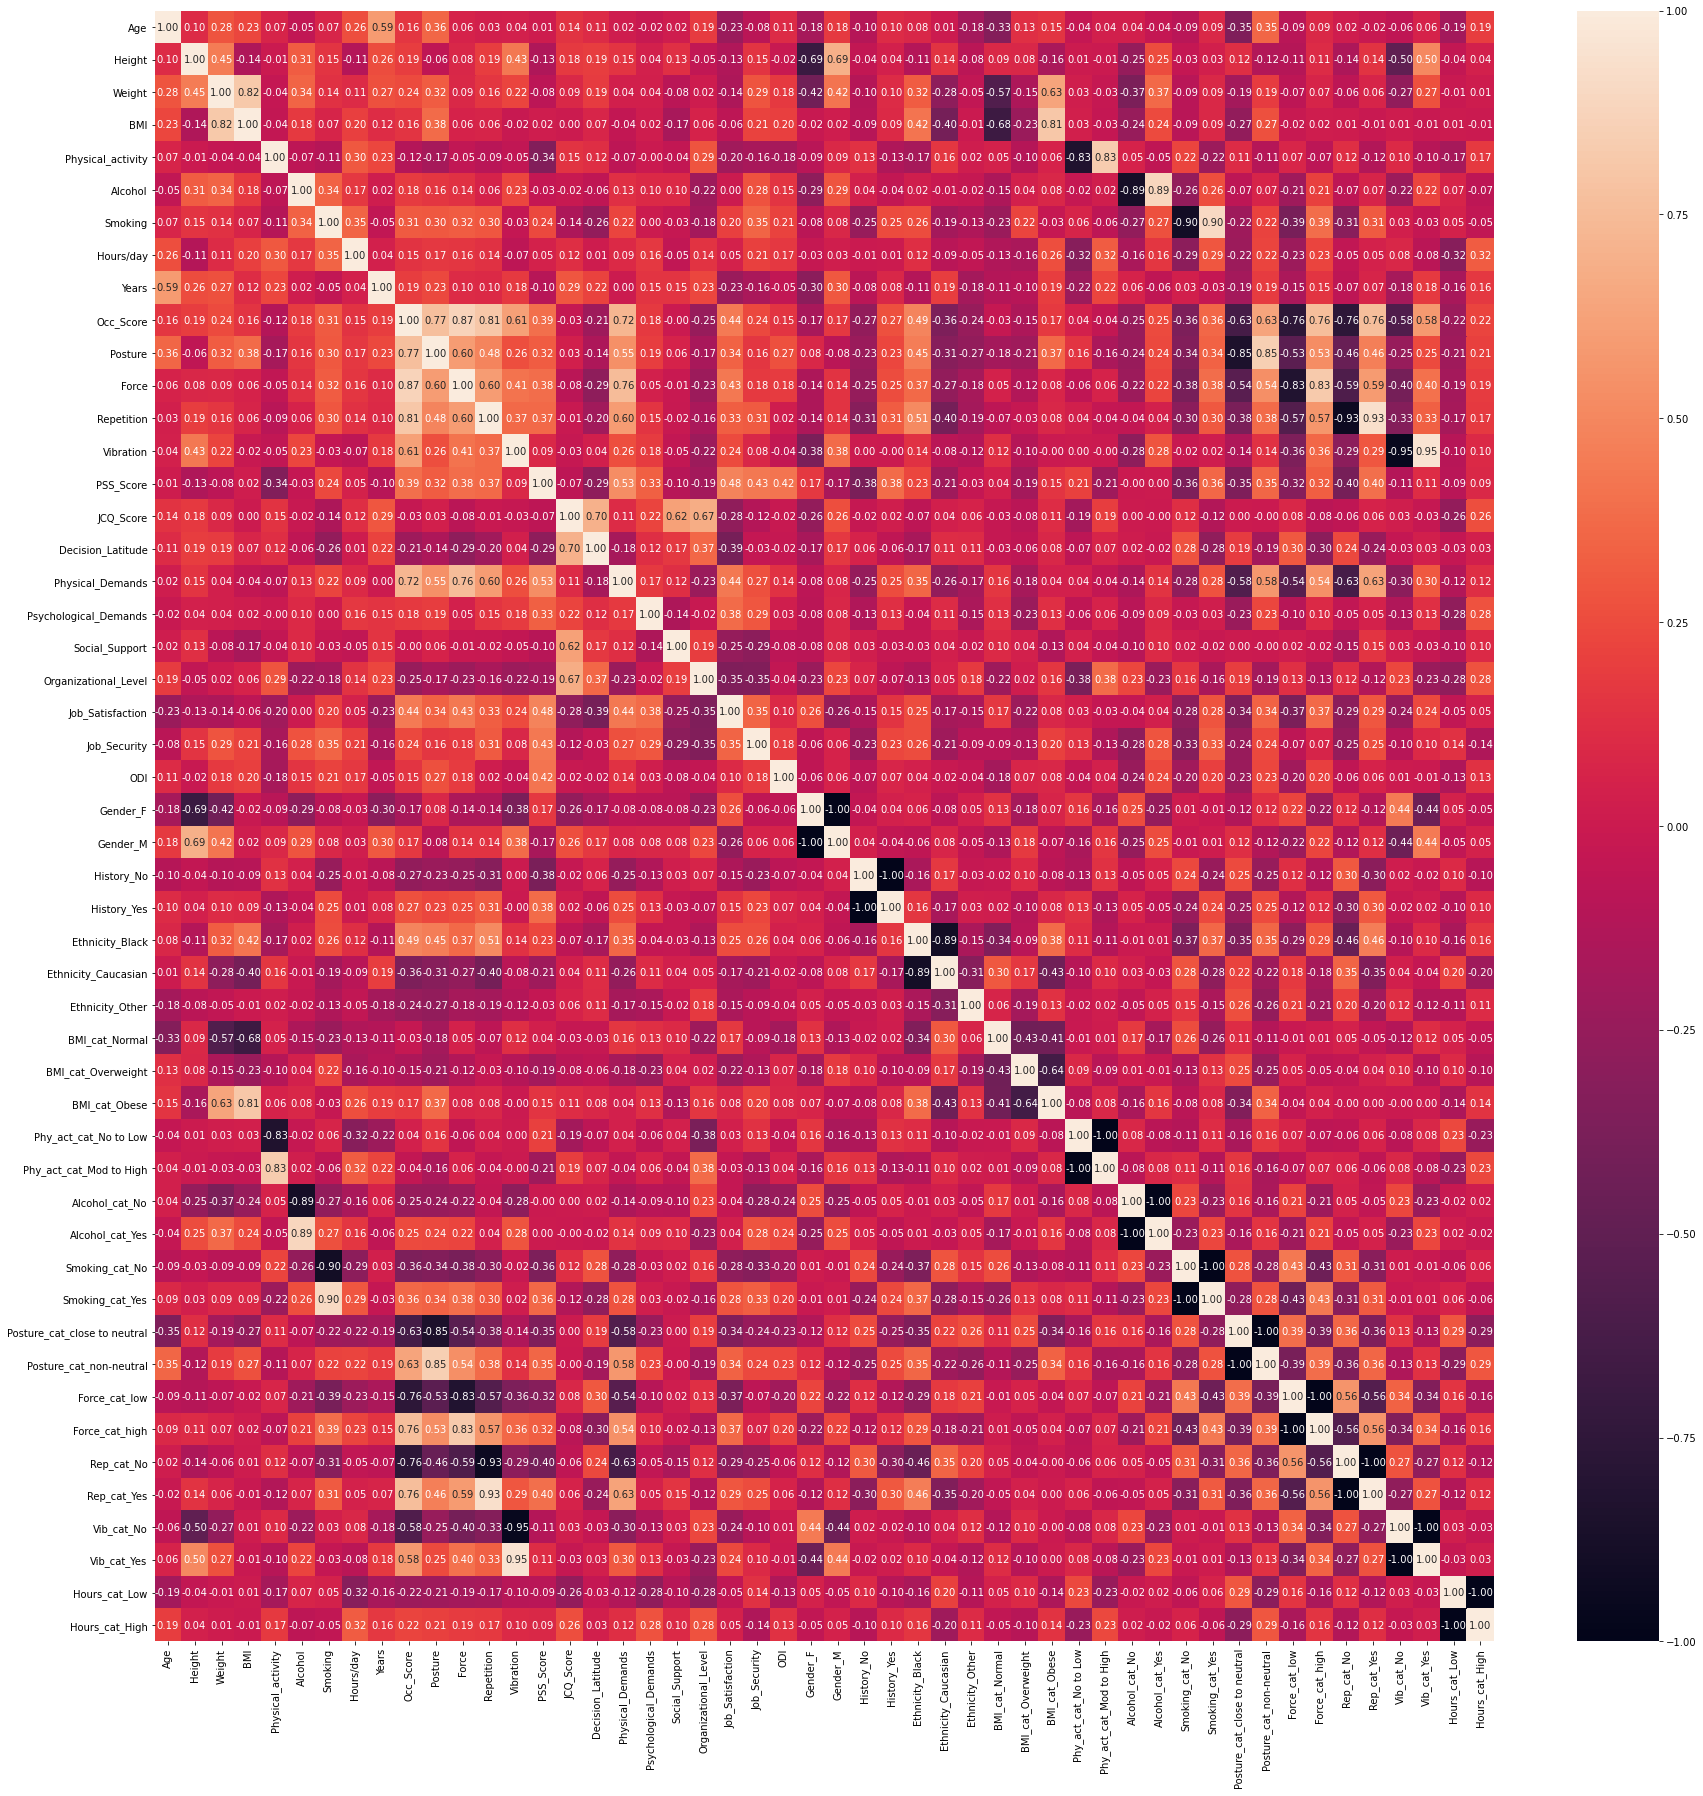

In [146]:
#Visualize correlation of target with other feathures
plt.subplots(figsize=(30,30))

corr = df_encoded.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

### Tertiary Classification

In [147]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='ODI'), 
                                                    df_encoded.ODI, test_size=0.3, 
                                                    random_state=47)

In [148]:
#Training
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

1    33
2     6
0     3
Name: ODI, dtype: int64
1    0.785714
2    0.142857
0    0.071429
Name: ODI, dtype: float64


In [149]:
#Test
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

1    14
2     3
0     1
Name: ODI, dtype: int64
1    0.777778
2    0.166667
0    0.055556
Name: ODI, dtype: float64


In [150]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model = clf.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=1)
Random Forest: Accuracy=0.778
Random Forest: f1-score=0.681


In [151]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [152]:
final_iv, IV = data_vars(X_train, y_train)

Age
0          NaN
1          NaN
2          NaN
3          NaN
4    -1.609438
5          NaN
6          NaN
7          NaN
8          NaN
9    -1.321756
10         NaN
11         NaN
12         NaN
13   -1.609438
14         NaN
15         NaN
16   -1.609438
17         NaN
dtype: float64
Height
0         NaN
1   -1.321756
2   -0.916291
3         NaN
4         NaN
5         NaN
6         NaN
7   -0.762140
8         NaN
9   -0.916291
dtype: float64
Weight
0    0.382992
1   -0.265703
dtype: float64
BMI


invalid value encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log


0         NaN
1    0.000000
2   -0.628609
dtype: float64
Physical_activity
0   -0.265703
1    0.382992
dtype: float64
Alcohol
0    0.847298
1   -1.098612
dtype: float64
Smoking
0         NaN
1   -1.034074
dtype: float64
Hours/day
0    0.427444
1   -0.310155
dtype: float64
Years
0   -0.628609
1    0.125163
2         NaN
dtype: float64
Occ_Score


invalid value encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log


0          NaN
1          NaN
2          NaN
3    -1.321756
4          NaN
5          NaN
6    -1.455287
7          NaN
8    -1.791759
9          NaN
10         NaN
11         NaN
12         NaN
dtype: float64
Posture
0         NaN
1   -0.310155
2   -0.693147
dtype: float64
Force
0    0.587787
1   -0.510826
dtype: float64
Repetition
0   -0.405465
1         NaN
dtype: float64
Vibration
0    0.182322
1   -0.510826
dtype: float64
PSS_Score
0          NaN
1          NaN
2    -1.321756
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8    -1.098612
9          NaN
10         NaN
11   -1.321756
12         NaN
13   -1.791759
dtype: float64
JCQ_Score
0   -0.265703
1    0.382992
dtype: float64
Decision_Latitude
0          NaN
1    -1.321756
2          NaN
3          NaN
4          NaN
5    -1.321756
6    -0.762140
7          NaN
8          NaN
9          NaN
10         NaN
11   -0.916291
12        -inf
13         NaN
dtype: float64
Physical_Demands
0          NaN
1     

divide by zero encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log
invalid value encountered in log


0         NaN
1   -0.671168
dtype: float64
Job_Security
0         NaN
1   -0.916291
2   -1.034074
dtype: float64
Gender_F
Gender_M
History_No
History_Yes
Ethnicity_Black
Ethnicity_Caucasian
Ethnicity_Other
BMI_cat_Normal
BMI_cat_Overweight
BMI_cat_Obese
Phy_act_cat_No to Low
Phy_act_cat_Mod to High
Alcohol_cat_No

invalid value encountered in log



Alcohol_cat_Yes
Smoking_cat_No
Smoking_cat_Yes
Posture_cat_close to neutral
Posture_cat_non-neutral
Force_cat_low
Force_cat_high
Rep_cat_No
Rep_cat_Yes
Vib_cat_No
Vib_cat_Yes
Hours_cat_Low
Hours_cat_High


In [153]:
X_train.head()

Age  Height  Weight        BMI  Physical_activity  Alcohol  Smoking  \
27   41      69     182  26.873766                  1        1        3   
10   57      65     233  38.768994                  3        1        1   
11   53      75     230  28.744889                  3        2        5   
19   52      72     238  32.275077                  5        2        1   
21   25      74     165  21.182432                  1        1        3   

    Hours/day  Years  Occ_Score  ...  Posture_cat_close to neutral  \
27          8   10.0         17  ...                             1   
10          8   13.0          9  ...                             0   
11          8    7.0         17  ...                             0   
19         10   30.0         27  ...                             0   
21          6   10.0         18  ...                             1   

    Posture_cat_non-neutral  Force_cat_low  Force_cat_high  Rep_cat_No  \
27                        0              0               1           0   
10                        1              1               0           1   
11                        1              0               1           0   
19                        1              0               1           0   
21                        0              0               1           0   

    Rep_cat_Yes  Vib_cat_No  Vib_cat_Yes  Hours_cat_Low  Hours_cat_High  
27            1           0            1              1               0  
10            0           1            0              1               0  
11            1           1            0              1               0  
19            1           0            1              0               1  
21            1           0            1              1               0  

[5 rows x 49 columns]

In [154]:
final_iv

VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
0               Age       20.0       25.0      3      3    1.000000         0   
1               Age       28.0       29.0      2      2    1.000000         0   
2               Age       30.0       33.0      2      2    1.000000         0   
3               Age       35.0       38.0      3      2    0.666667         1   
4               Age       39.0       39.0      2      3    1.500000        -1   
..              ...        ...        ...    ...    ...         ...       ...   
190     Vib_cat_Yes        1.0        1.0      8      9    1.125000        -1   
191   Hours_cat_Low        0.0        0.0     20     22    1.100000        -2   
192   Hours_cat_Low        1.0        1.0     22     23    1.045455        -1   
193  Hours_cat_High        0.0        0.0     22     23    1.045455        -1   
194  Hours_cat_High        1.0        1.0     20     22    1.100000        -2   

     NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
0          0.000000    0.066667       -0.000000       NaN  1.610646  
1          0.000000    0.044444       -0.000000       NaN  1.610646  
2          0.000000    0.044444       -0.000000       NaN  1.610646  
3          0.333333    0.044444       -0.333333       NaN  1.610646  
4         -0.500000    0.066667        0.333333 -1.609438  1.610646  
..              ...         ...             ...       ...       ...  
190       -0.125000    0.200000        0.333333 -0.510826  0.092420  
191       -0.100000    0.488889        0.666667 -0.310155  0.131129  
192       -0.045455    0.511111        0.333333  0.427444  0.131129  
193       -0.045455    0.511111        0.333333  0.427444  0.131129  
194       -0.100000    0.488889        0.666667 -0.310155  0.131129  

[195 rows x 12 columns]

In [155]:
IV

VAR_NAME        IV
0                            Age  1.610646
1                        Alcohol  0.864849
2                 Alcohol_cat_No  1.089761
3                Alcohol_cat_Yes  1.089761
4                            BMI  0.195567
5                 BMI_cat_Normal  0.247085
6                  BMI_cat_Obese  0.008629
7             BMI_cat_Overweight  0.450517
8              Decision_Latitude  0.964941
9                Ethnicity_Black  0.082708
10           Ethnicity_Caucasian  0.135155
11               Ethnicity_Other  0.004600
12                         Force  0.292963
13                Force_cat_high  0.292963
14                 Force_cat_low  0.292963
15                      Gender_F  0.165336
16                      Gender_M  0.165336
17                        Height  0.825104
18                    History_No  0.400666
19                   History_Yes  0.400666
20                     Hours/day  0.131129
21                Hours_cat_High  0.131129
22                 Hours_cat_Low  0.131129
23                     JCQ_Score  0.100908
24              Job_Satisfaction  0.328127
25                  Job_Security  1.216178
26                     Occ_Score  2.062331
27          Organizational_Level  2.589765
28                     PSS_Score  1.885750
29       Phy_act_cat_Mod to High  0.529094
30         Phy_act_cat_No to Low  0.529094
31              Physical_Demands  1.509317
32             Physical_activity  0.100908
33                       Posture  0.258618
34  Posture_cat_close to neutral  0.231617
35       Posture_cat_non-neutral  0.231617
36         Psychological_Demands  0.261239
37                    Rep_cat_No  0.135155
38                   Rep_cat_Yes  0.135155
39                    Repetition  0.135155
40                       Smoking  0.666403
41                Smoking_cat_No  0.666403
42               Smoking_cat_Yes  0.666403
43                Social_Support  1.740534
44                    Vib_cat_No  0.092420
45                   Vib_cat_Yes  0.092420
46                     Vibration  0.092420
47                        Weight  0.100908
48                         Years  0.201130

In [156]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(42, 35)

BMI  BMI_cat_Normal  BMI_cat_Overweight  Ethnicity_Black  \
27  26.873766               0                   1                1   
10  38.768994               0                   0                1   
11  28.744889               0                   1                0   
19  32.275077               0                   0                1   
21  21.182432               1                   0                0   

    Ethnicity_Caucasian  Force  Force_cat_high  Force_cat_low  Gender_F  \
27                    0      5               1              0         0   
10                    0      2               0              1         1   
11                    1      5               1              0         0   
19                    0      7               1              0         0   
21                    1      6               1              0         0   

    Gender_M  ...  Rep_cat_Yes  Repetition  Smoking  Smoking_cat_No  \
27         1  ...            1           4        3               0   
10         0  ...            0           0        1               1   
11         1  ...            1           4        5               0   
19         1  ...            1           7        1               1   
21         1  ...            1           4        3               0   

    Smoking_cat_Yes  Vib_cat_No  Vib_cat_Yes  Vibration  Weight  Years  
27                1           0            1          3     182   10.0  
10                0           1            0          0     233   13.0  
11                1           1            0          0     230    7.0  
19                0           0            1          5     238   30.0  
21                1           0            1          3     165   10.0  

[5 rows x 35 columns]

In [157]:
display(X2.shape[1])
for i in range(X2.shape[1]):
    print((i, variance_inflation_factor(X2.values, i) ))

35

(0, 32.603864893116345)
(1, 15.47957966076714)
(2, 8.570796125416775)
(3, 14.867314907620877)
(4, 10.040372107450597)
(5, 7.37080805397901)
(6, inf)
(7, inf)
(8, inf)
(9, inf)
(10, inf)
(11, inf)
(12, 4.223211432309868)
(13, inf)
(14, inf)
(15, 4.98080047195178)
(16, 4.856444194101379)
(17, inf)
(18, inf)
(19, 6.992432114763879)
(20, 22.162337260372198)
(21, inf)
(22, inf)
(23, 3.3708846631392726)
(24, inf)
(25, inf)
(26, 27.88356249732435)
(27, 22.33811603882889)
(28, inf)
(29, inf)
(30, inf)
(31, inf)
(32, 19.163529632293304)
(33, 15.69192781982491)
(34, 5.052397828759731)


divide by zero encountered in double_scalars


In [158]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Force_cat_high with VIF of inf
Iteration # 2
Removing Gender_F with VIF of inf
Iteration # 3
Removing History_No with VIF of inf
Iteration # 4
Removing Hours_cat_High with VIF of inf
Iteration # 5
Removing Phy_act_cat_Mod to High with VIF of inf
Iteration # 6
Removing Posture_cat_close to neutral with VIF of inf
Iteration # 7


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing Rep_cat_No with VIF of inf
Iteration # 8
Removing Smoking_cat_No with VIF of inf
Iteration # 9
Removing Vib_cat_No with VIF of 485.889106
Iteration # 10
Removing BMI with VIF of 516.593133
Iteration # 11
Removing Posture with VIF of 262.092664
Iteration # 12
Removing Weight with VIF of 121.969768
Iteration # 13
Removing JCQ_Score with VIF of 57.138630
Iteration # 14
Removing Smoking with VIF of 43.448876
Iteration # 15
Removing Repetition with VIF of 24.863708
Iteration # 16
Removing Ethnicity_Caucasian with VIF of 22.507156
Iteration # 17
Removing Vib_cat_Yes with VIF of 16.589464
Iteration # 18
Removing Physical_activity with VIF of 14.350650
Iteration # 19
Removing Force with VIF of 12.110690
Iteration # 20
Removing Psychological_Demands with VIF of 8.813955
Iteration # 21
Complete


In [159]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

15

Index(['BMI_cat_Normal', 'BMI_cat_Overweight', 'Ethnicity_Black',
       'Force_cat_low', 'Gender_M', 'History_Yes', 'Hours/day',
       'Hours_cat_Low', 'Job_Satisfaction', 'Phy_act_cat_No to Low',
       'Posture_cat_non-neutral', 'Rep_cat_Yes', 'Smoking_cat_Yes',
       'Vibration', 'Years'],
      dtype='object')

BMI_cat_Normal  BMI_cat_Overweight  Ethnicity_Black  Force_cat_low  \
27               0                   1                1              0   
10               0                   0                1              1   
11               0                   1                0              0   
19               0                   0                1              0   
21               1                   0                0              0   

    Gender_M  History_Yes  Hours/day  Hours_cat_Low  Job_Satisfaction  \
27         1            1          8              1          0.800000   
10         0            0          8              1          0.000000   
11         1            1          8              1          0.133333   
19         1            1         10              0          0.266667   
21         1            1          6              1          0.466667   

    Phy_act_cat_No to Low  Posture_cat_non-neutral  Rep_cat_Yes  \
27                      1                        0            1   
10                      1                        1            0   
11                      1                        1            1   
19                      0                        1            1   
21                      1                        0            1   

    Smoking_cat_Yes  Vibration  Years  
27                1          3   10.0  
10                0          0   13.0  
11                1          0    7.0  
19                0          5   30.0  
21                1          3   10.0

### Binary Classification

In [197]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded2.drop(columns='ODI2'), 
                                                    df_encoded2.ODI2, test_size=0.3, 
                                                    random_state=47)

In [198]:
#Training
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

0    25
1    17
Name: ODI2, dtype: int64
0    0.595238
1    0.404762
Name: ODI2, dtype: float64


In [199]:
#Test
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    9
1    9
Name: ODI2, dtype: int64
0    0.5
1    0.5
Name: ODI2, dtype: float64


In [200]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model = clf.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=1)
Random Forest: Accuracy=0.611
Random Forest: f1-score=0.610


In [201]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [202]:
final_iv, IV = data_vars(X_train, y_train)

Age
0         -inf
1          inf
2         -inf
3         -inf
4     0.385662
5         -inf
6         -inf
7     0.791128
8          NaN
9     1.078810
10         inf
11        -inf
12         NaN
13    0.385662
14    1.484275
15        -inf
16    0.385662
17    1.078810
dtype: float64
Height
0    0.385662
1         inf
2   -0.019803
3   -0.712950
4   -0.019803
5         NaN
6        -inf
7    0.385662
8         NaN
9   -0.019803
dtype: float64
Weight
0   -0.099845
1    0.097980
dtype: float64
BMI

divide by zero encountered in log
divide by zero encountered in log



0   -1.118415
1   -0.019803
2    0.385662
3    0.567984
dtype: float64
Physical_activity
0   -0.307485
1    0.290352
dtype: float64
Alcohol
0   -0.351936
1    1.484275
dtype: float64
Smoking
0   -0.579418
1    1.196593
dtype: float64
Hours/day
0   -0.173953
1    0.184992
dtype: float64
Years
0    0.017938
1   -0.019803
dtype: float64
Occ_Score
0    -0.712950
1    -1.223775
2          NaN
3     1.078810
4    -1.000632
5         -inf
6    -0.019803
7     1.078810
8     1.078810
9     0.385662
10   -0.307485
11         inf
12    0.385662
dtype: float64
Posture
0   -0.936093
1    0.385662
2    0.567984
3    1.078810
dtype: float64
Force
0   -0.530628
1    0.097980
2    0.673345
dtype: float64
Repetition
0   -0.144966
1    0.252131
dtype: float64
Vibration
0    0.149274
1   -0.712950
dtype: float64

divide by zero encountered in log
divide by zero encountered in log



PSS_Score
0         -inf
1         -inf
2    -0.307485
3     1.078810
4          NaN
5         -inf
6     0.385662
7    -0.712950
8     0.385662
9          NaN
10        -inf
11         inf
12         inf
13    1.078810
dtype: float64
JCQ_Score
0    0.097980
1   -0.099845
dtype: float64
Decision_Latitude
0     1.078810
1     1.078810
2    -0.307485
3    -0.019803
4          inf
5     1.078810
6     0.385662
7          NaN
8    -1.000632
9         -inf
10         NaN
11   -0.019803
12        -inf
13   -0.307485
dtype: float64
Physical_Demands


divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log


0    -0.712950
1    -1.000632
2     0.385662
3          NaN
4    -0.019803
5    -0.530628
6          NaN
7     1.078810
8          inf
9     0.385662
10        -inf
dtype: float64
Psychological_Demands
0   -0.173953
1    0.184992
dtype: float64
Social_Support
0   -0.712950
1    1.484275
2    0.791128
3         NaN
4    0.673345
5    0.385662
6    1.078810
7        -inf
8        -inf
9   -1.000632
dtype: float64
Organizational_Level
0     1.078810
1     0.385662
2          NaN
3     0.385662
4    -0.307485
5     1.484275
6          NaN
7     1.078810
8         -inf
9         -inf
10        -inf
11        -inf
12        -inf
13        -inf
14    0.385662
15    1.078810
16         inf
17        -inf
18    0.385662
dtype: float64
Job_Satisfaction
0   -1.118415
1   -0.173953
2    0.385662
3    0.791128
dtype: float64
Job_Security
0   -0.913621
1   -0.019803
2    0.855666
dtype: float64
Gender_F
Gender_M
History_No
History_Yes
Ethnicity_Black
Ethnicity_Caucasian
Ethnicity_Other
BMI_cat_Norma

divide by zero encountered in log



Posture_cat_close to neutral
Posture_cat_non-neutral
Force_cat_low
Force_cat_high
Rep_cat_No
Rep_cat_Yes
Vib_cat_No
Vib_cat_Yes
Hours_cat_Low
Hours_cat_High


In [203]:
X_train.head()

Age  Height  Weight        BMI  Physical_activity  Alcohol  Smoking  \
27   41      69     182  26.873766                  1        1        3   
10   57      65     233  38.768994                  3        1        1   
11   53      75     230  28.744889                  3        2        5   
19   52      72     238  32.275077                  5        2        1   
21   25      74     165  21.182432                  1        1        3   

    Hours/day  Years  Occ_Score  ...  Posture_cat_close to neutral  \
27          8   10.0         17  ...                             1   
10          8   13.0          9  ...                             0   
11          8    7.0         17  ...                             0   
19         10   30.0         27  ...                             0   
21          6   10.0         18  ...                             1   

    Posture_cat_non-neutral  Force_cat_low  Force_cat_high  Rep_cat_No  \
27                        0              0               1           0   
10                        1              1               0           1   
11                        1              0               1           0   
19                        1              0               1           0   
21                        0              0               1           0   

    Rep_cat_Yes  Vib_cat_No  Vib_cat_Yes  Hours_cat_Low  Hours_cat_High  
27            1           0            1              1               0  
10            0           1            0              1               0  
11            1           1            0              1               0  
19            1           0            1              0               1  
21            1           0            1              1               0  

[5 rows x 49 columns]

In [204]:
final_iv

VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  EVENT_RATE  NONEVENT  \
0               Age       20.0       25.0      3      0    0.000000         3   
1               Age       28.0       29.0      2      2    1.000000         0   
2               Age       30.0       33.0      2      0    0.000000         2   
3               Age       35.0       38.0      3      0    0.000000         3   
4               Age       39.0       39.0      2      1    0.500000         1   
..              ...        ...        ...    ...    ...         ...       ...   
194     Vib_cat_Yes        1.0        1.0      8      2    0.250000         6   
195   Hours_cat_Low        0.0        0.0     20      9    0.450000        11   
196   Hours_cat_Low        1.0        1.0     22      8    0.363636        14   
197  Hours_cat_High        0.0        0.0     22      8    0.363636        14   
198  Hours_cat_High        1.0        1.0     20      9    0.450000        11   

     NON_EVENT_RATE  DIST_EVENT  DIST_NON_EVENT       WOE        IV  
0          1.000000    0.000000            0.12  0.000000  0.468192  
1          0.000000    0.117647            0.00  0.000000  0.468192  
2          1.000000    0.000000            0.08  0.000000  0.468192  
3          1.000000    0.000000            0.12  0.000000  0.468192  
4          0.500000    0.058824            0.04  0.385662  0.468192  
..              ...         ...             ...       ...       ...  
194        0.750000    0.117647            0.24 -0.712950  0.105496  
195        0.550000    0.529412            0.44  0.184992  0.032094  
196        0.636364    0.470588            0.56 -0.173953  0.032094  
197        0.636364    0.470588            0.56 -0.173953  0.032094  
198        0.550000    0.529412            0.44  0.184992  0.032094  

[199 rows x 12 columns]

In [205]:
IV

VAR_NAME        IV
0                            Age  0.468192
1                        Alcohol  0.501178
2                 Alcohol_cat_No  0.391815
3                Alcohol_cat_Yes  0.391815
4                            BMI  0.394310
5                 BMI_cat_Normal  0.173789
6                  BMI_cat_Obese  0.264936
7             BMI_cat_Overweight  0.031774
8              Decision_Latitude  0.387434
9                Ethnicity_Black  0.061727
10           Ethnicity_Caucasian  0.000217
11               Ethnicity_Other  0.015340
12                         Force  0.169872
13                Force_cat_high  0.890733
14                 Force_cat_low  0.890733
15                      Gender_F  0.114632
16                      Gender_M  0.114632
17                        Height  0.094572
18                    History_No  0.019772
19                   History_Yes  0.019772
20                     Hours/day  0.032094
21                Hours_cat_High  0.032094
22                 Hours_cat_Low  0.032094
23                     JCQ_Score  0.009775
24              Job_Satisfaction  0.467767
25                  Job_Security  0.472439
26                     Occ_Score  0.604520
27          Organizational_Level  0.496668
28                     PSS_Score  0.330465
29       Phy_act_cat_Mod to High  0.478444
30         Phy_act_cat_No to Low  0.478444
31              Physical_Demands  0.399692
32             Physical_activity  0.088621
33                       Posture  0.617578
34  Posture_cat_close to neutral  0.577738
35       Posture_cat_non-neutral  0.577738
36         Psychological_Demands  0.032094
37                    Rep_cat_No  0.036439
38                   Rep_cat_Yes  0.036439
39                    Repetition  0.036439
40                       Smoking  0.656079
41                Smoking_cat_No  0.656079
42               Smoking_cat_Yes  0.656079
43                Social_Support  0.643270
44                    Vib_cat_No  0.105496
45                   Vib_cat_Yes  0.105496
46                     Vibration  0.105496
47                        Weight  0.009775
48                         Years  0.000355

In [206]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(42, 43)

Age  Alcohol  Alcohol_cat_No  Alcohol_cat_Yes        BMI  BMI_cat_Normal  \
27   41        1               1                0  26.873766               0   
10   57        1               1                0  38.768994               0   
11   53        2               0                1  28.744889               0   
19   52        2               0                1  32.275077               0   
21   25        1               1                0  21.182432               1   

    BMI_cat_Obese  BMI_cat_Overweight  Decision_Latitude  Ethnicity_Black  \
27              0                   1                 62                1   
10              1                   0                 78                1   
11              0                   1                 66                0   
19              1                   0                 68                1   
21              0                   0                 66                0   

    ...  Rep_cat_No  Rep_cat_Yes  Repetition  Smoking  Smoking_cat_No  \
27  ...           0            1           4        3               0   
10  ...           1            0           0        1               1   
11  ...           0            1           4        5               0   
19  ...           0            1           7        1               1   
21  ...           0            1           4        3               0   

    Smoking_cat_Yes  Social_Support  Vib_cat_No  Vib_cat_Yes  Vibration  
27                1              18           0            1          3  
10                0              35           1            0          0  
11                1              30           1            0          0  
19                0              32           0            1          5  
21                1              32           0            1          3  

[5 rows x 43 columns]

In [207]:
display(X2.shape[1])
for i in range(X2.shape[1]):
    print((i, variance_inflation_factor(X2.values, i) ))

43

(0, 5.876327592833626)
(1, 16.296307039318688)
(2, inf)
(3, inf)
(4, 16.934690061860106)
(5, inf)
(6, inf)
(7, inf)
(8, 6.769030422159987)
(9, 7.640549484822477)
(10, 3.5756933735629746)
(11, inf)
(12, inf)
(13, inf)
(14, 8.898257228011852)
(15, inf)
(16, inf)
(17, 4.175534053521159)
(18, inf)
(19, inf)
(20, 7.887188382643006)
(21, 5.687323011985523)
(22, inf)
(23, 7.7693663685937935)
(24, 10.559045609806622)
(25, inf)
(26, inf)
(27, 9.580946219760584)
(28, 21.30340444942297)
(29, inf)
(30, inf)
(31, inf)
(32, 5.641127393084305)
(33, inf)
(34, inf)
(35, inf)
(36, 20.957140218534413)
(37, inf)
(38, inf)
(39, 3.3179400036267976)
(40, inf)
(41, inf)
(42, inf)


divide by zero encountered in double_scalars


In [208]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Alcohol_cat_No with VIF of inf
Iteration # 2
Removing BMI_cat_Normal with VIF of inf
Iteration # 3
Removing Force with VIF of inf
Iteration # 4
Removing Gender_F with VIF of inf
Iteration # 5


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing History_No with VIF of inf
Iteration # 6
Removing Hours_cat_High with VIF of inf
Iteration # 7
Removing Phy_act_cat_Mod to High with VIF of inf
Iteration # 8
Removing Posture_cat_close to neutral with VIF of inf
Iteration # 9
Removing Rep_cat_No with VIF of inf
Iteration # 10
Removing Smoking_cat_No with VIF of inf
Iteration # 11


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing Vib_cat_No with VIF of 2089.887533
Iteration # 12
Removing Height with VIF of 833.954830
Iteration # 13
Removing Posture with VIF of 421.913306
Iteration # 14
Removing BMI with VIF of 289.445039
Iteration # 15
Removing Decision_Latitude with VIF of 180.700486
Iteration # 16
Removing Occ_Score with VIF of 122.727996
Iteration # 17
Removing PSS_Score with VIF of 72.991166
Iteration # 18
Removing Age with VIF of 53.019423
Iteration # 19
Removing Smoking with VIF of 48.936667
Iteration # 20
Removing Alcohol with VIF of 43.629827
Iteration # 21
Removing Physical_Demands with VIF of 30.473098
Iteration # 22
Removing Repetition with VIF of 26.491861
Iteration # 23
Removing Organizational_Level with VIF of 25.676419
Iteration # 24
Removing Vib_cat_Yes with VIF of 20.547036
Iteration # 25
Removing Phy_act_cat_No to Low with VIF of 13.192429
Iteration # 26
Removing Social_Support with VIF of 8.814096
Iteration # 27
Removing Psychological_Demands with VIF of 6.068514
Iteration # 28
Remov

In [209]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

15

Index(['Alcohol_cat_Yes', 'BMI_cat_Overweight', 'Ethnicity_Black',
       'Ethnicity_Other', 'Gender_M', 'History_Yes', 'Hours/day',
       'Hours_cat_Low', 'Job_Satisfaction', 'Job_Security',
       'Physical_activity', 'Posture_cat_non-neutral', 'Rep_cat_Yes',
       'Smoking_cat_Yes', 'Vibration'],
      dtype='object')

Alcohol_cat_Yes  BMI_cat_Overweight  Ethnicity_Black  Ethnicity_Other  \
27                0                   1                1                0   
10                0                   0                1                0   
11                1                   1                0                0   
19                1                   0                1                0   
21                0                   0                0                0   

    Gender_M  History_Yes  Hours/day  Hours_cat_Low  Job_Satisfaction  \
27         1            1          8              1          0.800000   
10         0            0          8              1          0.000000   
11         1            1          8              1          0.133333   
19         1            1         10              0          0.266667   
21         1            1          6              1          0.466667   

    Job_Security  Physical_activity  Posture_cat_non-neutral  Rep_cat_Yes  \
27             4                  1                        0            1   
10             0                  3                        1            0   
11             7                  3                        1            1   
19             1                  5                        1            1   
21             2                  1                        0            1   

    Smoking_cat_Yes  Vibration  
27                1          3  
10                0          0  
11                1          0  
19                0          5  
21                1          3

### Regression

In [286]:
#Drop categorical variables
names_list = ['bins', 'Ethnicity', 'Gender', 'History', 'BMI_cat', 'Phy_act_cat', 'Alcohol_cat', 'Smoking_cat', 'Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat', 'Hours_cat', 'ODI', 'ODI2', 'VAS']
dff3=df.drop(columns=names_list)

In [287]:
dff3.shape

(60, 24)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(dff3.drop(columns='ODI_Score'), 
                                                    dff3.ODI_Score, test_size=0.3, 
                                                    random_state=47)

In [289]:
X_train.shape, X_test.shape

((42, 23), (18, 23))

In [290]:
y_train.shape, y_test.shape

((42,), (18,))

In [291]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

Age                        int64
Height                     int64
Weight                     int64
BMI                      float64
Physical_activity          int64
Alcohol                    int64
Smoking                    int64
Hours/day                  int64
Years                    float64
Occ_Score                  int64
Posture                    int64
Force                      int64
Repetition                 int64
Vibration                  int64
PSS_Score                  int64
JCQ_Score                float64
Decision_Latitude          int64
Physical_Demands           int64
Psychological_Demands      int64
Social_Support             int64
Organizational_Level       int64
Job_Satisfaction         float64
Job_Security               int64
dtype: object

In [292]:
X_test.dtypes

Age                        int64
Height                     int64
Weight                     int64
BMI                      float64
Physical_activity          int64
Alcohol                    int64
Smoking                    int64
Hours/day                  int64
Years                    float64
Occ_Score                  int64
Posture                    int64
Force                      int64
Repetition                 int64
Vibration                  int64
PSS_Score                  int64
JCQ_Score                float64
Decision_Latitude          int64
Physical_Demands           int64
Psychological_Demands      int64
Social_Support             int64
Organizational_Level       int64
Job_Satisfaction         float64
Job_Security               int64
dtype: object

In [293]:
pipe = make_pipeline( 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [294]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7fc56ca9b1f0>)),
                ('linearregression', LinearRegression())])

In [295]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [296]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.48734057801603226, 0.10092053702158199)

In [297]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.438872799463768, 11.434304355754543)

In [298]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [299]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [300]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fc56ca9b1f0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23]})

In [301]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [302]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 4}

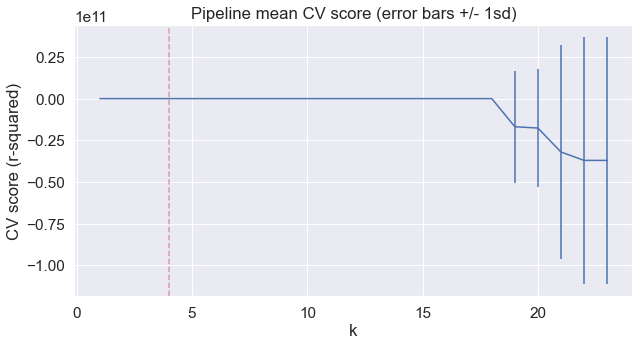

In [303]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [304]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [305]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Alcohol      5.069685
PSS_Score    4.968002
Posture      3.113809
Smoking      2.082519
dtype: float64

In [306]:
#Random Forest Model
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [307]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [308]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-5.79973875e+00, -5.80892645e-02, -1.14886151e-01, -8.58242286e-02,
        4.52375418e-03])

In [309]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-1.210802927993274, 2.2948076332881415)

In [310]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [311]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [312]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [313]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 69, 'standardscaler': None}

In [314]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-4.93270584, -0.1034711 , -0.09837952, -0.09294542,  0.03253851])

In [315]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-1.0389926733336963, 1.94751844262403)

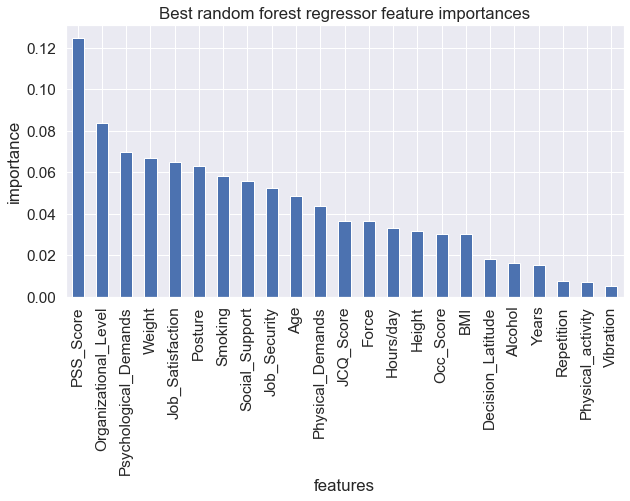

In [316]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [317]:
#Linear regression model performance
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [318]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(11.231872368940868, 1.7462422260203347)

In [319]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

9.672604787349343

In [334]:
mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test), squared=False)

11.811076688397154

In [320]:
#Random forest regression model performance
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [321]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(13.280112721417069, 1.3685463127594506)

In [322]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

10.85829307568438

In [335]:
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test), squared=False)

4.707154542469445

In [323]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

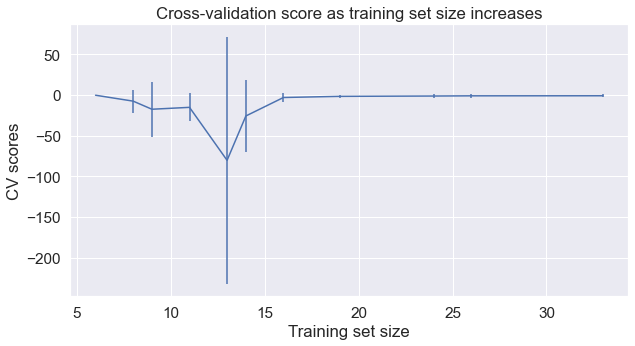

In [324]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## 4. Modelling

### Tertiary Classification

In [160]:
X_test=X_test[X_train.columns]
X_test.head()

BMI_cat_Normal  BMI_cat_Overweight  Ethnicity_Black  Force_cat_low  \
46               0                   1                0              0   
36               0                   0                1              1   
49               1                   0                0              1   
54               0                   1                0              1   
12               0                   0                0              0   

    Gender_M  History_Yes  Hours/day  Hours_cat_Low  Job_Satisfaction  \
46         1            0          7              1          0.200000   
36         0            1          8              1          0.466667   
49         0            0          8              1          0.200000   
54         0            0          5              1          0.300000   
12         1            0         12              0          0.200000   

    Phy_act_cat_No to Low  Posture_cat_non-neutral  Rep_cat_Yes  \
46                      0                        0            1   
36                      1                        1            1   
49                      0                        1            0   
54                      1                        0            0   
12                      0                        1            1   

    Smoking_cat_Yes  Vibration  Years  
46                0          0    2.0  
36                1          0    4.0  
49                0          0    9.0  
54                0          0    1.0  
12                0          4   50.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.06304687 0.03191891 0.00930387 0.03899097 0.03654019 0.10202733
 0.21704652 0.03409272 0.15170734 0.03160678 0.01593657 0.00041132
 0.04474337 0.0452854  0.17734186]


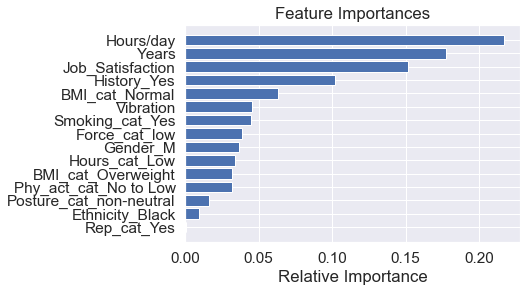

[[ 0  1  0]
 [ 0 14  0]
 [ 0  3  0]]


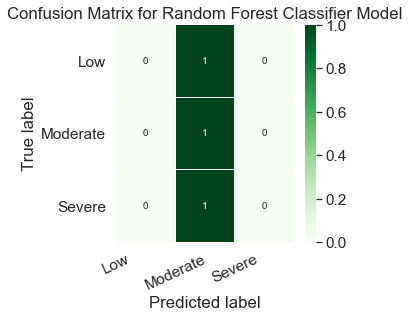

In [180]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



#roc1 = roc_auc_score(y_test, y_pred1)

#roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Moderate', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()

In [181]:
# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

#roc3 = roc_auc_score(y_test, y_pred3)

#roc3

[21:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "oob_score", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:57:14] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:57:14] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[21:57:14] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[21:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objectiv

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 0  1  0]
 [ 0 12  2]
 [ 0  3  0]]


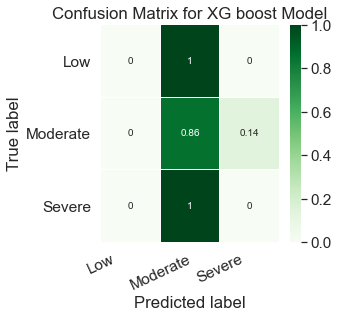

In [166]:
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Moderate', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [167]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.86      0.80        14
           2       0.00      0.00      0.00         3

    accuracy                           0.67        18
   macro avg       0.25      0.29      0.27        18
weighted avg       0.58      0.67      0.62        18



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [169]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [170]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

In [171]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


The least populated class in y has only 3 members, which is less than n_splits=5.
One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier obj

[22:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:soft

[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:05:42] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, ma

In [172]:
print(model.best_score_)
print(model.best_params_)

nan
{'eta': 0.01, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 9, 'scale_pos_weight': 49}


In [173]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)

[22:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "scoring_fit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:09:07] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, m

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.01, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=4, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50,
              scoring_fit='roc_auc', subsample=1, tree_method='exact', ...)

[[ 0  1  0]
 [ 0 11  3]
 [ 0  3  0]]


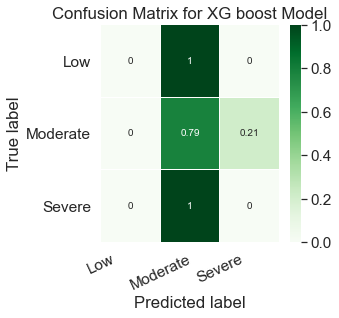

In [184]:
y_pred=pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Moderate', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.73      0.79      0.76        14
           2       0.00      0.00      0.00         3

    accuracy                           0.61        18
   macro avg       0.24      0.26      0.25        18
weighted avg       0.57      0.61      0.59        18



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


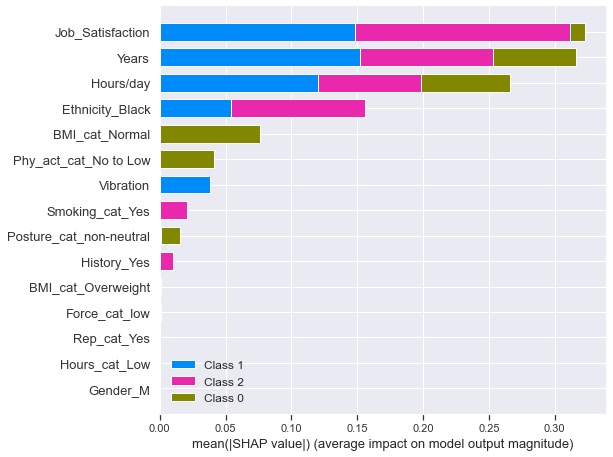

In [177]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

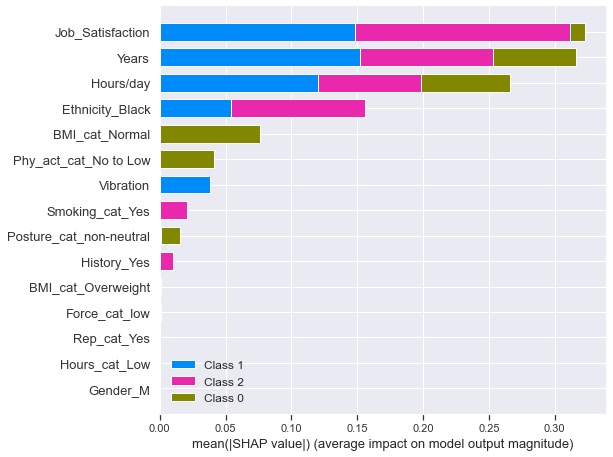

In [178]:
shap.summary_plot(shap_values, X_train)

### Binary Classification

In [210]:
X_test=X_test[X_train.columns]
X_test.head()

Alcohol_cat_Yes  BMI_cat_Overweight  Ethnicity_Black  Ethnicity_Other  \
46                0                   1                0                0   
36                0                   0                1                0   
49                1                   0                0                0   
54                1                   1                0                0   
12                1                   0                0                0   

    Gender_M  History_Yes  Hours/day  Hours_cat_Low  Job_Satisfaction  \
46         1            0          7              1          0.200000   
36         0            1          8              1          0.466667   
49         0            0          8              1          0.200000   
54         0            0          5              1          0.300000   
12         1            0         12              0          0.200000   

    Job_Security  Physical_activity  Posture_cat_non-neutral  Rep_cat_Yes  \
46            -1                  4                        0            1   
36             6                  3                        1            1   
49             0                  4                        1            0   
54             2                  3                        0            0   
12            -1                  5                        1            1   

    Smoking_cat_Yes  Vibration  
46                0          0  
36                1          0  
49                0          0  
54                0          0  
12                0          4

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.04765146 0.0309226  0.01237553 0.06179285 0.0395764  0.04259974
 0.17424532 0.01397757 0.23425469 0.06180473 0.11341843 0.06744277
 0.03130157 0.02297315 0.04566319]


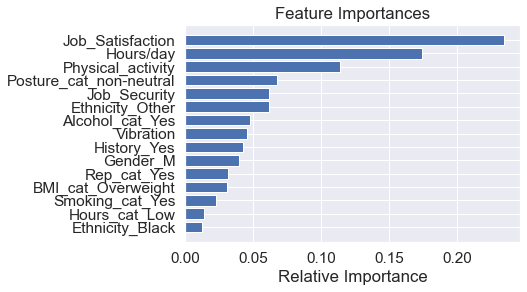

[[7 2]
 [6 3]]


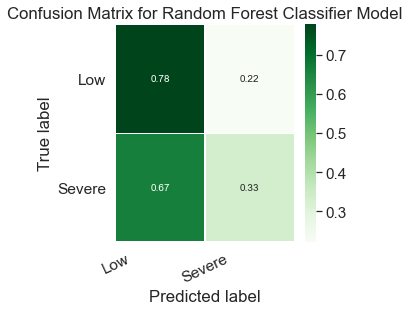

In [211]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



roc1 = roc_auc_score(y_test, y_pred1)

roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()

In [212]:
# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3

[22:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "oob_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:34:32] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:34:32] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:34:32] INFO: /Users/runner/work/

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.5555555555555556

[[1 8]
 [0 9]]


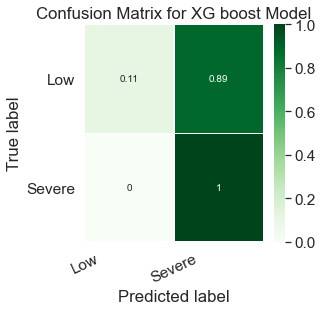

In [213]:
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [214]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.53      1.00      0.69         9

    accuracy                           0.56        18
   macro avg       0.76      0.56      0.45        18
weighted avg       0.76      0.56      0.45        18



0.5555555555555556


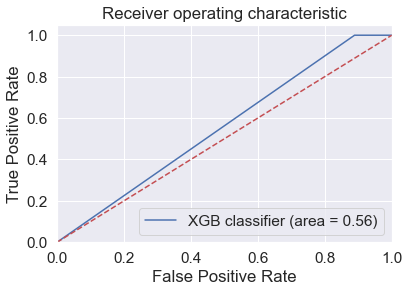

In [215]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

plt.figure()
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [216]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [217]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

In [218]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[22:38:20] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:38:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:38:20] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:38:20] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:38:20] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:38:20] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc

One or more of the test scores are non-finite: [0.52       0.52       0.52       0.52       0.52       0.52
 0.52       0.52       0.52       0.52       0.52       0.52
 0.52       0.52       0.52       0.52       0.52       0.52
 0.52       0.52       0.52       0.52       0.52       0.52
 0.52       0.52       0.52              nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.53333333 0.53333333 0.50666667 0.53333333 0.53333333 0.50666667
 0.53333333 0.53333333 0.50666667 0.53333333 0.53333333 0.50666667
 0.53333333 0.53333333 0.50666667 0.53333333 0.53333333 0.50666667
 0.53333333 0.53333333 0.50666667 0.53333333 0.53333333 0.50666667
 0.53333333 0.53333333 0.50666667        nan        nan        nan
        nan        nan        nan      

In [219]:
print(model.best_score_)
print(model.best_params_)

0.5533333333333333
{'eta': 0.1, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 9, 'scale_pos_weight': 50}


In [220]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)

[22:38:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scoring_fit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:38:51] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:38:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:38:51] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:38:51] INFO: /Users/runner/wor

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.01, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=4, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=50, scoring_fit='roc_auc', subsample=1,
              tree_method='exact', validate_parameters=1, ...)

Test 0.5555555555555556


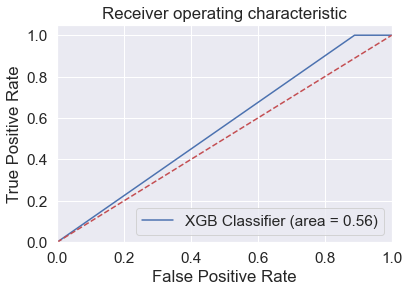

In [221]:
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

print("Test",roc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

[[2 7]
 [2 7]]


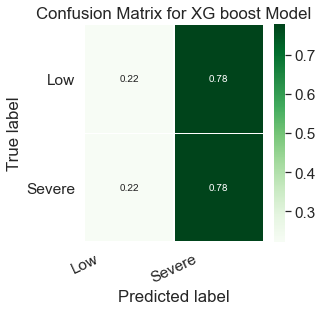

In [222]:
y_pred=pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [223]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.50      0.78      0.61         9

    accuracy                           0.50        18
   macro avg       0.50      0.50      0.46        18
weighted avg       0.50      0.50      0.46        18



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


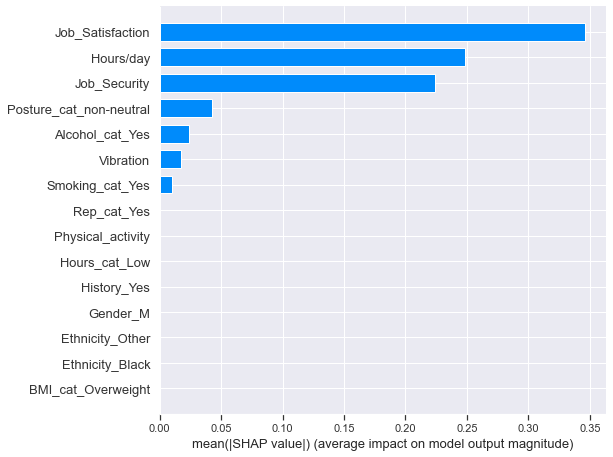

In [224]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

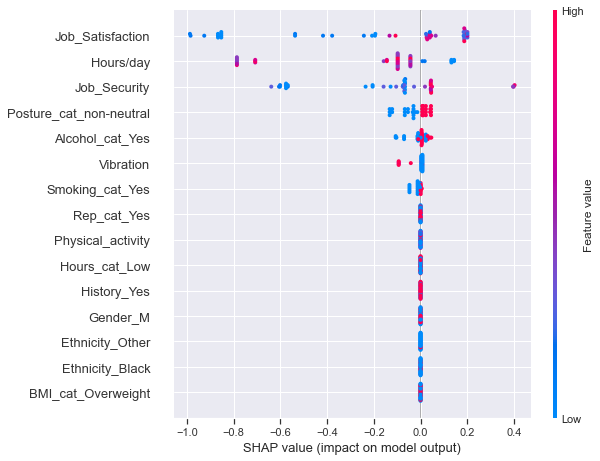

In [225]:
shap.summary_plot(shap_values, X_train)

### Regression

In [327]:
X = dff3.drop(columns='ODI_Score')
y = dff3.ODI_Score

In [328]:
len(X), len(y)

(60, 60)

In [330]:
rf_grid_cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [331]:
cv_results = cross_validate(rf_grid_cv, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [336]:
cv_results['test_score']

array([-17.70772947, -11.04464286, -10.23809524,  -9.55555556,
       -13.73232323])

In [337]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(12.455669270343183, 2.984401827860695)

In [341]:
mean_squared_error(y, rf_grid_cv.predict(X), squared=False)

5.6473063159279535